Detailed explanation:
https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da

GitHub repo:
https://github.com/alexppppp/keypoint_rcnn_training_pytorch

# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [4]:
!pip install pycocotools
!pip install Scrapy
!pip install transforms


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 kB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 9.8 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for lxml: filename=

In [ ]:
%cd /content/keypoint_rcnn_training_pytorch

In [5]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

## Set the default sigma values for 6 keypoints detection in COCO evaluation to: kpt_oks_sigmas=[.26, .25, .25, .35, .35, .79] in the coco_eval.py (or also try to: [.3, .3, .3, .3, .3, .3])

# 2. Augmentations

In [6]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

# 3. Dataset class

In [7]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        

        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are lower body
            bboxes_labels_original = ['lower body' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
  
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,6, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                #print(obj)
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)

            
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are lower bodies
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are lower bodies
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [10]:
KEYPOINTS_FOLDER_TRAIN = '/Users/marie-alix/Documents/PDM/MoveUP/Pose3D/ROM/dataset/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[151.4300, 124.0400, 481.0600, 305.0000]]), 'labels': tensor([1]), 'image_id': tensor([57]), 'area': tensor([59649.8438]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[431.2047, 262.5492,   1.0000],
         [429.9276, 237.0157,   1.0000],
         [318.1797, 252.8919,   1.0000],
         [381.7332, 153.3647,   1.0000],
         [211.9689, 256.1384,   1.0000],
         [322.6262, 232.9742,   1.0000]]])}, {'boxes': tensor([[204.1100, 136.7800, 491.2600, 283.7500]]), 'labels': tensor([1]), 'image_id': tensor([481]), 'area': tensor([42202.4375]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[461.3242, 264.9547,   1.0000],
         [446.9849, 256.8868,   1.0000],
         [393.1584, 163.6539,   1.0000],
         [330.7012, 251.1335,   1.0000],
         [316.8697, 248.1220,   1.0000],
         [241.2172, 253.1716,   1.0000]]])}, {'boxes': tensor([[100.4600, 179.2600, 473.4200, 335.5800]]), 'labels': tensor([1]), 'image_id': tensor([320]), 'area': ten

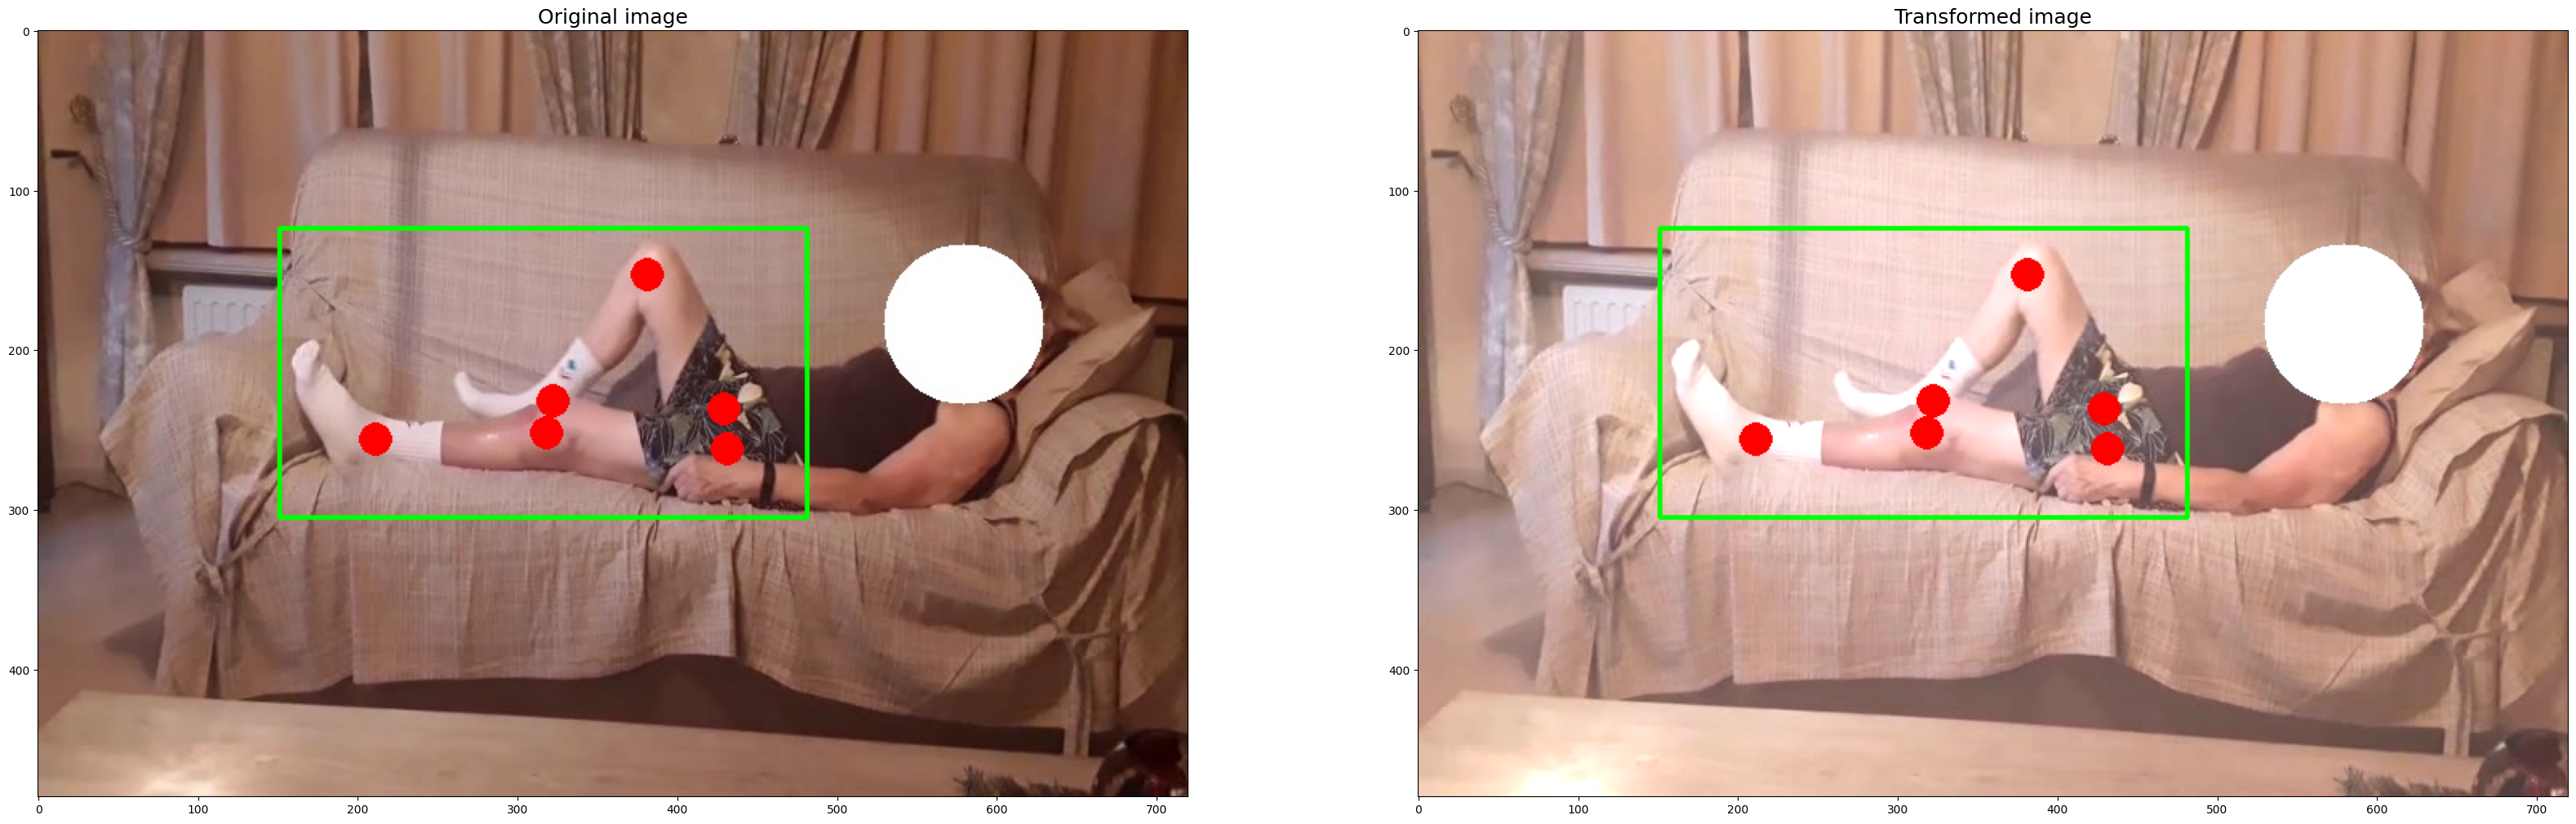

In [11]:
keypoints_classes_ids2names = {0: 'left_hip', 1: 'right_hip', 2: 'left_knee', 3: 'right_knee', 4: 'left_ankle', 5: 'right_ankle'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3]) 
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            #image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3]) 
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                #image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

       
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

Here, we use one of the pre-trained models provided by Detectron2: keypointrcnn_resnet50_fpn. We might want to try an other model.

In [12]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = '/Users/marie-alix/Documents/PDM/MoveUP/Pose3D/ROM/dataset/train'
KEYPOINTS_FOLDER_TEST = '/Users/marie-alix/Documents/PDM/MoveUP/Pose3D/ROM/dataset/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 6)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.05)
#optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=0.5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), 'keypointsrcnn_weights.pth')

Epoch: [0]  [  0/187]  eta: 0:45:00  lr: 0.000064  loss: 9.4376 (9.4376)  loss_classifier: 0.6950 (0.6950)  loss_box_reg: 0.0051 (0.0051)  loss_keypoint: 8.0453 (8.0453)  loss_objectness: 0.6857 (0.6857)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 14.4417  data: 0.0310
Epoch: [0]  [186/187]  eta: 0:00:16  lr: 0.010000  loss: 7.6648 (7.9028)  loss_classifier: 0.0768 (0.1106)  loss_box_reg: 0.0818 (0.0618)  loss_keypoint: 7.4493 (7.5956)  loss_objectness: 0.0232 (0.1283)  loss_rpn_box_reg: 0.0052 (0.0066)  time: 18.0481  data: 0.0250
Epoch: [0] Total time: 0:51:58 (16.6779 s / it)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [  0/170]  eta: 0:09:19  model_time: 3.2774 (3.2774)  evaluator_time: 0.0108 (0.0108)  time: 3.2925  data: 0.0039
Test:  [100/170]  eta: 0:03:25  model_time: 2.6423 (2.9229)  evaluator_time: 0.0055 (0.0057)  time: 2.7441  data: 0.0074
Test:  [169/170]  eta: 0:00:02  model_time: 2.4012 (2.7143)  evaluator_time: 0.0046 (0.0053)  time: 2.4785  data: 0.0065
Test: Total time: 0:07:43 (2.7263 s / it)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
IoU metric: keypoints
Epoch: [1]  [  0/187]  eta: 1:04:57  lr: 0.010000  loss: 7.8448 (7.8448)  loss_classifier: 0.0615 (0.0615)  loss_box_reg: 0.0695 (0.0695)  loss_keypoint: 7.6934 (7.6934)  loss_objectness: 0.0157 (0.0157)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 20.8436  data: 0.0238
Epoch: [1]  [186/187]  eta: 0:00:16  lr: 0.010000  loss: 7.7221 (7.8694)  loss_classifier: 0.0737 (0.0736)  loss_box_reg: 0.0768 (0.0737)  loss_keypoint:

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [  0/170]  eta: 0:07:52  model_time: 2.7696 (2.7696)  evaluator_time: 0.0083 (0.0083)  time: 2.7815  data: 0.0036
Test:  [100/170]  eta: 0:02:49  model_time: 2.4447 (2.4092)  evaluator_time: 0.0053 (0.0049)  time: 2.4931  data: 0.0067
Test:  [169/170]  eta: 0:00:02  model_time: 2.6530 (2.4565)  evaluator_time: 0.0054 (0.0051)  time: 2.6736  data: 0.0059
Test: Total time: 0:06:59 (2.4677 s / it)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
IoU metric: keypoints
Epoch: [2]  [  0/187]  eta: 1:02:52  lr: 0.010000  loss: 7.4438 (7.4438)  loss_classifier: 0.0693 (0.0693)  loss_box_reg: 0.0798 (0.0798)  loss_keypoint: 7.2754 (7.2754)  loss_objectness: 0.0178 (0.0178)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 20.1734  data: 0.0210
Epoch: [2]  [186/187]  eta: 0:00:16  lr: 0.010000  loss: 7.6654 (7.6491)  loss_classifier: 0.0658 (0.0670)  loss_box_reg: 0.0770 (0.0686)  loss_keypoint:

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [  0/170]  eta: 0:11:30  model_time: 4.0465 (4.0465)  evaluator_time: 0.0105 (0.0105)  time: 4.0602  data: 0.0032
Test:  [100/170]  eta: 0:04:09  model_time: 3.5373 (3.5458)  evaluator_time: 0.0079 (0.0081)  time: 3.5733  data: 0.0061
Test:  [169/170]  eta: 0:00:03  model_time: 3.5895 (3.5699)  evaluator_time: 0.0080 (0.0081)  time: 3.6299  data: 0.0051
Test: Total time: 0:10:09 (3.5835 s / it)
Accumulating evaluation results...
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
IoU metric: keypoints
Epoch: [3]  [  0/187]  eta: 1:07:14  lr: 0.010000  loss: 7.8325 (7.8325)  loss_classifier: 0.0853 (0.0853)  loss_box_reg: 0.0994 (0.0994)  loss_keypoint: 7.6090 (7.6090)  loss_objectness: 0.0284 (0.0284)  loss_rpn_box_reg: 0.0103 (0.0103)  time: 21.5723  data: 0.0234


KeyboardInterrupt: 

In [15]:
import json
path_to_annotations = '/Users/marie-alix/Documents/PDM/MoveUP/Pose3D/ROM/dataset/train/annotations'
annotations_list = os.listdir(path_to_annotations)

for annotations_file in annotations_list:
  # Load annotations from JSON file
  annotations = json.load(open(path_to_annotations + '/' + annotations_file))
  # Loop through each annotation and check if the bounding box is valid
  bbox = annotations['bboxes'][0]
  x1, y1, x2, y2 = bbox
  w = x2 - x1
  h = y2 - y1
  if w <= 0 or h <= 0:
      print(f"Invalid box found: {bbox}")

# 6. Visualizing model predictions

/var/folders/fj/z2550dyd69b728kx9jk__sdw0000gn/T/ipykernel_3742/1550039197.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(40,40))


KeyboardInterrupt: 

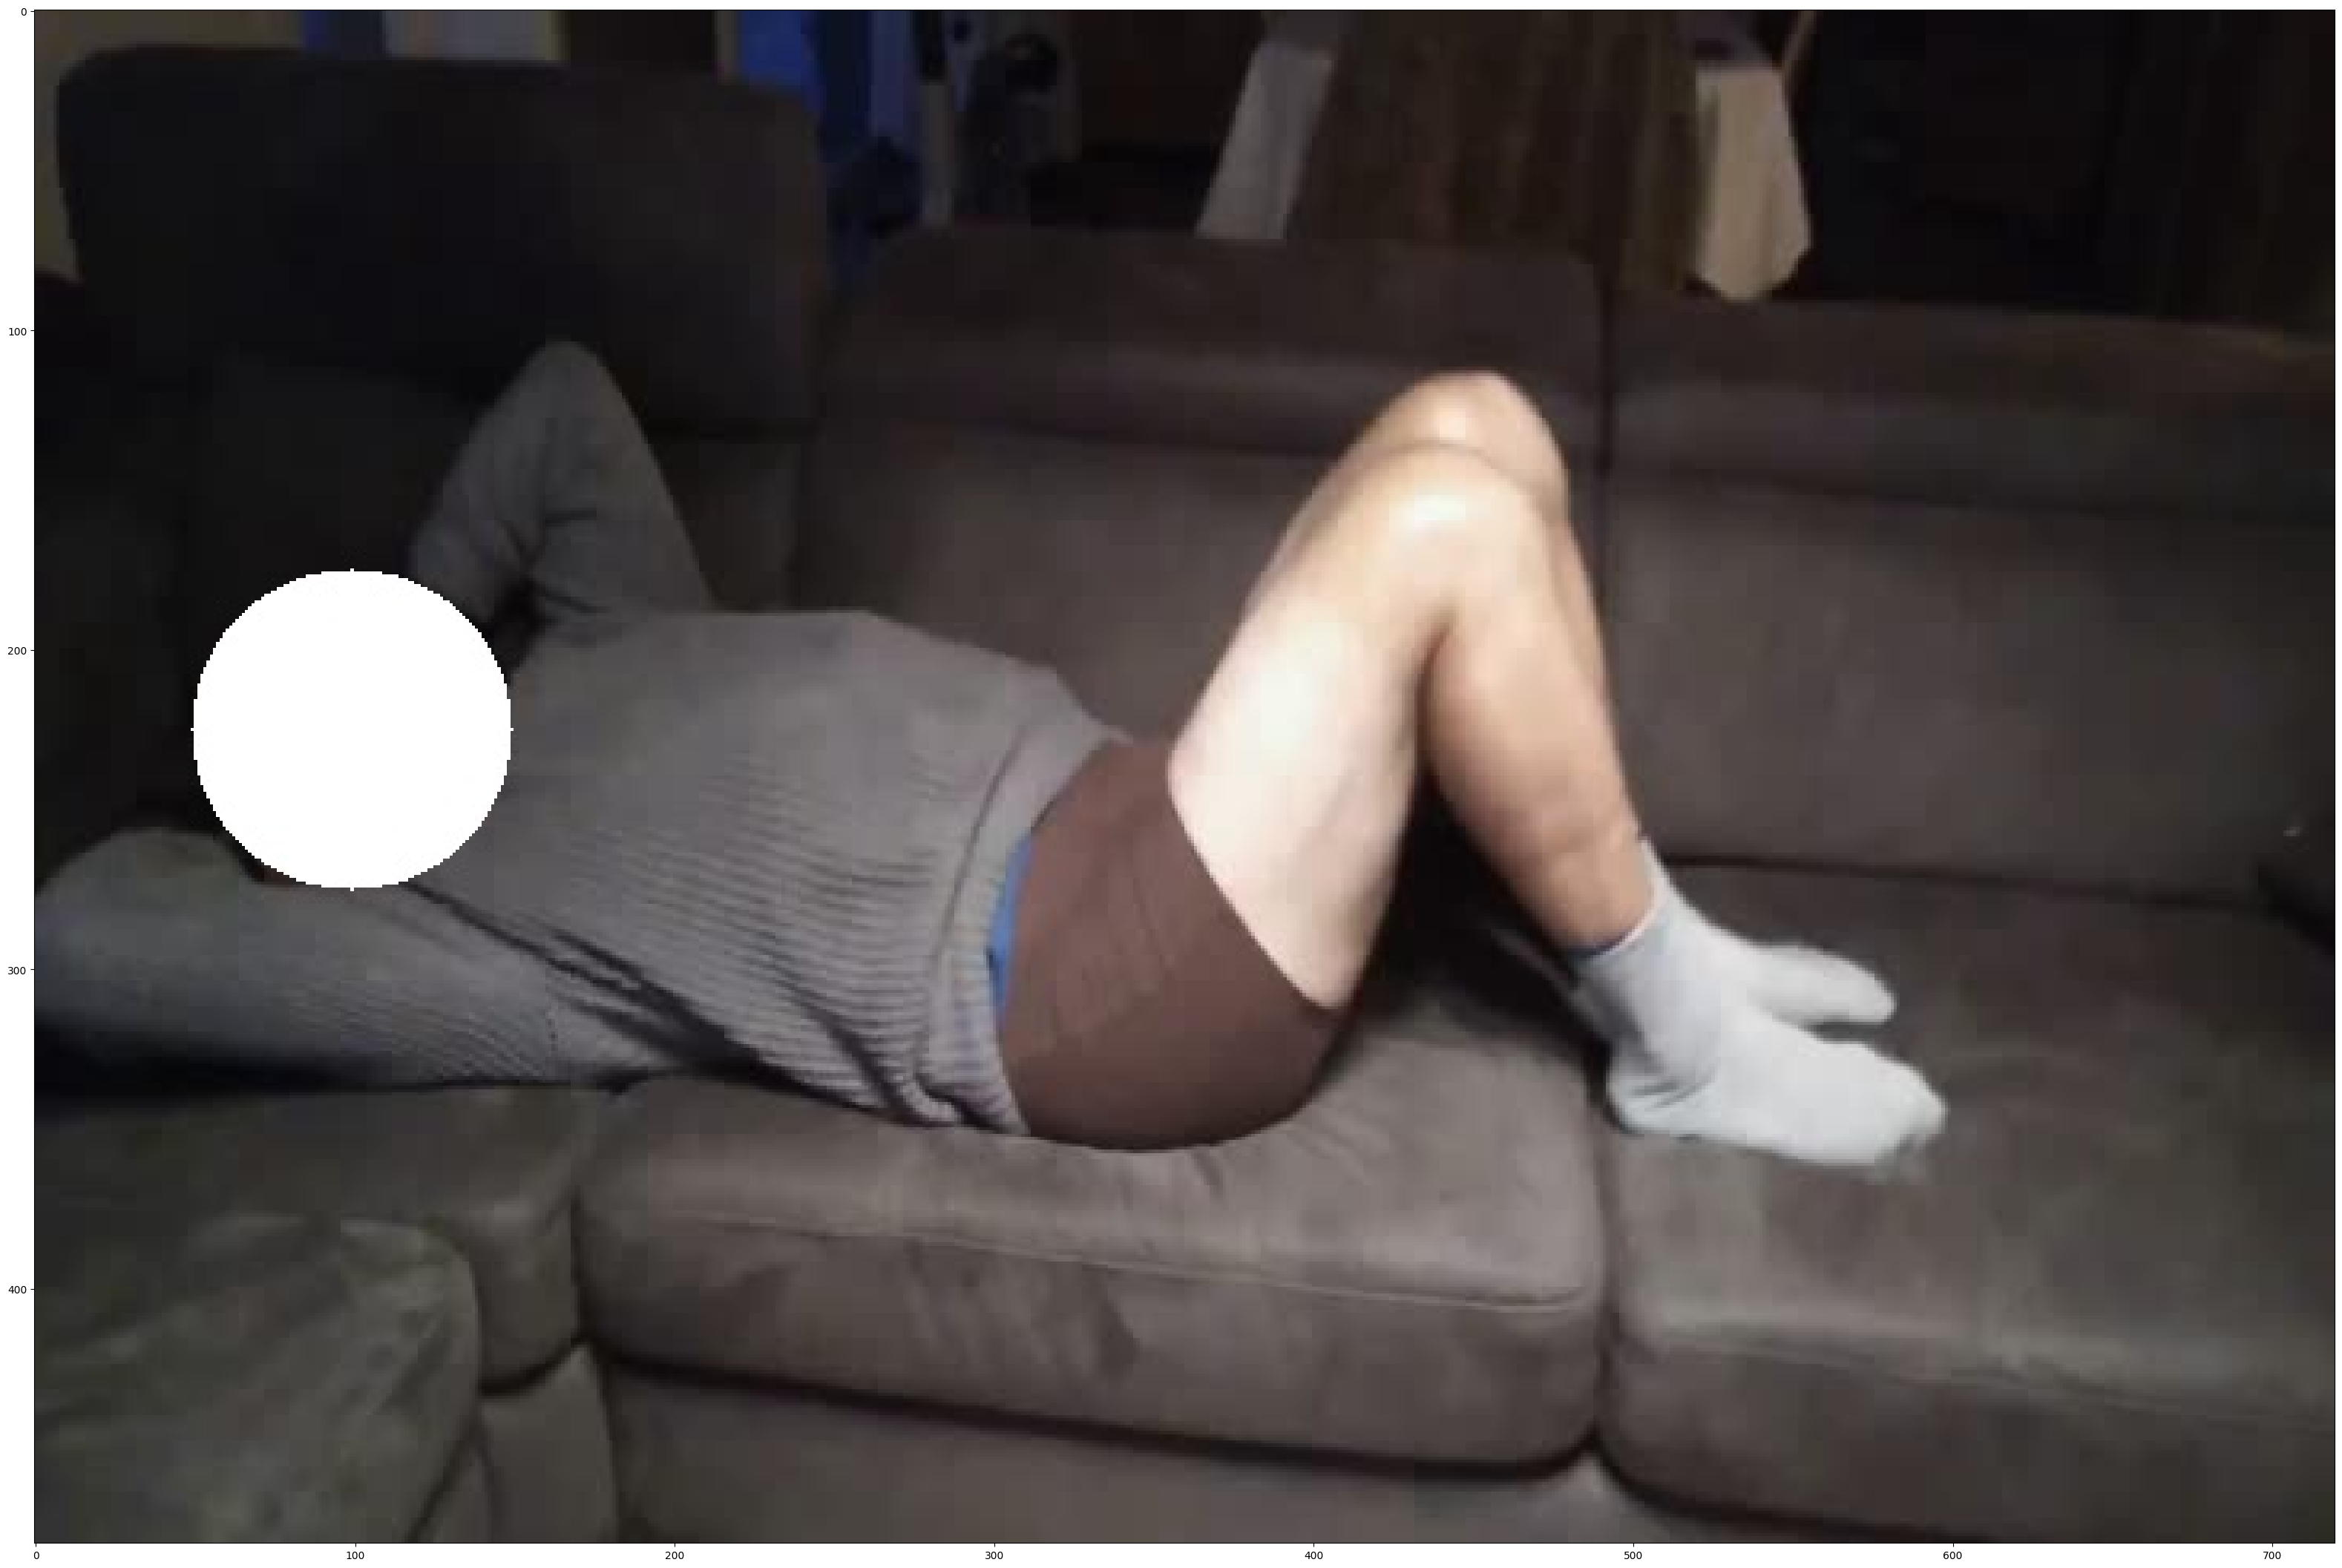

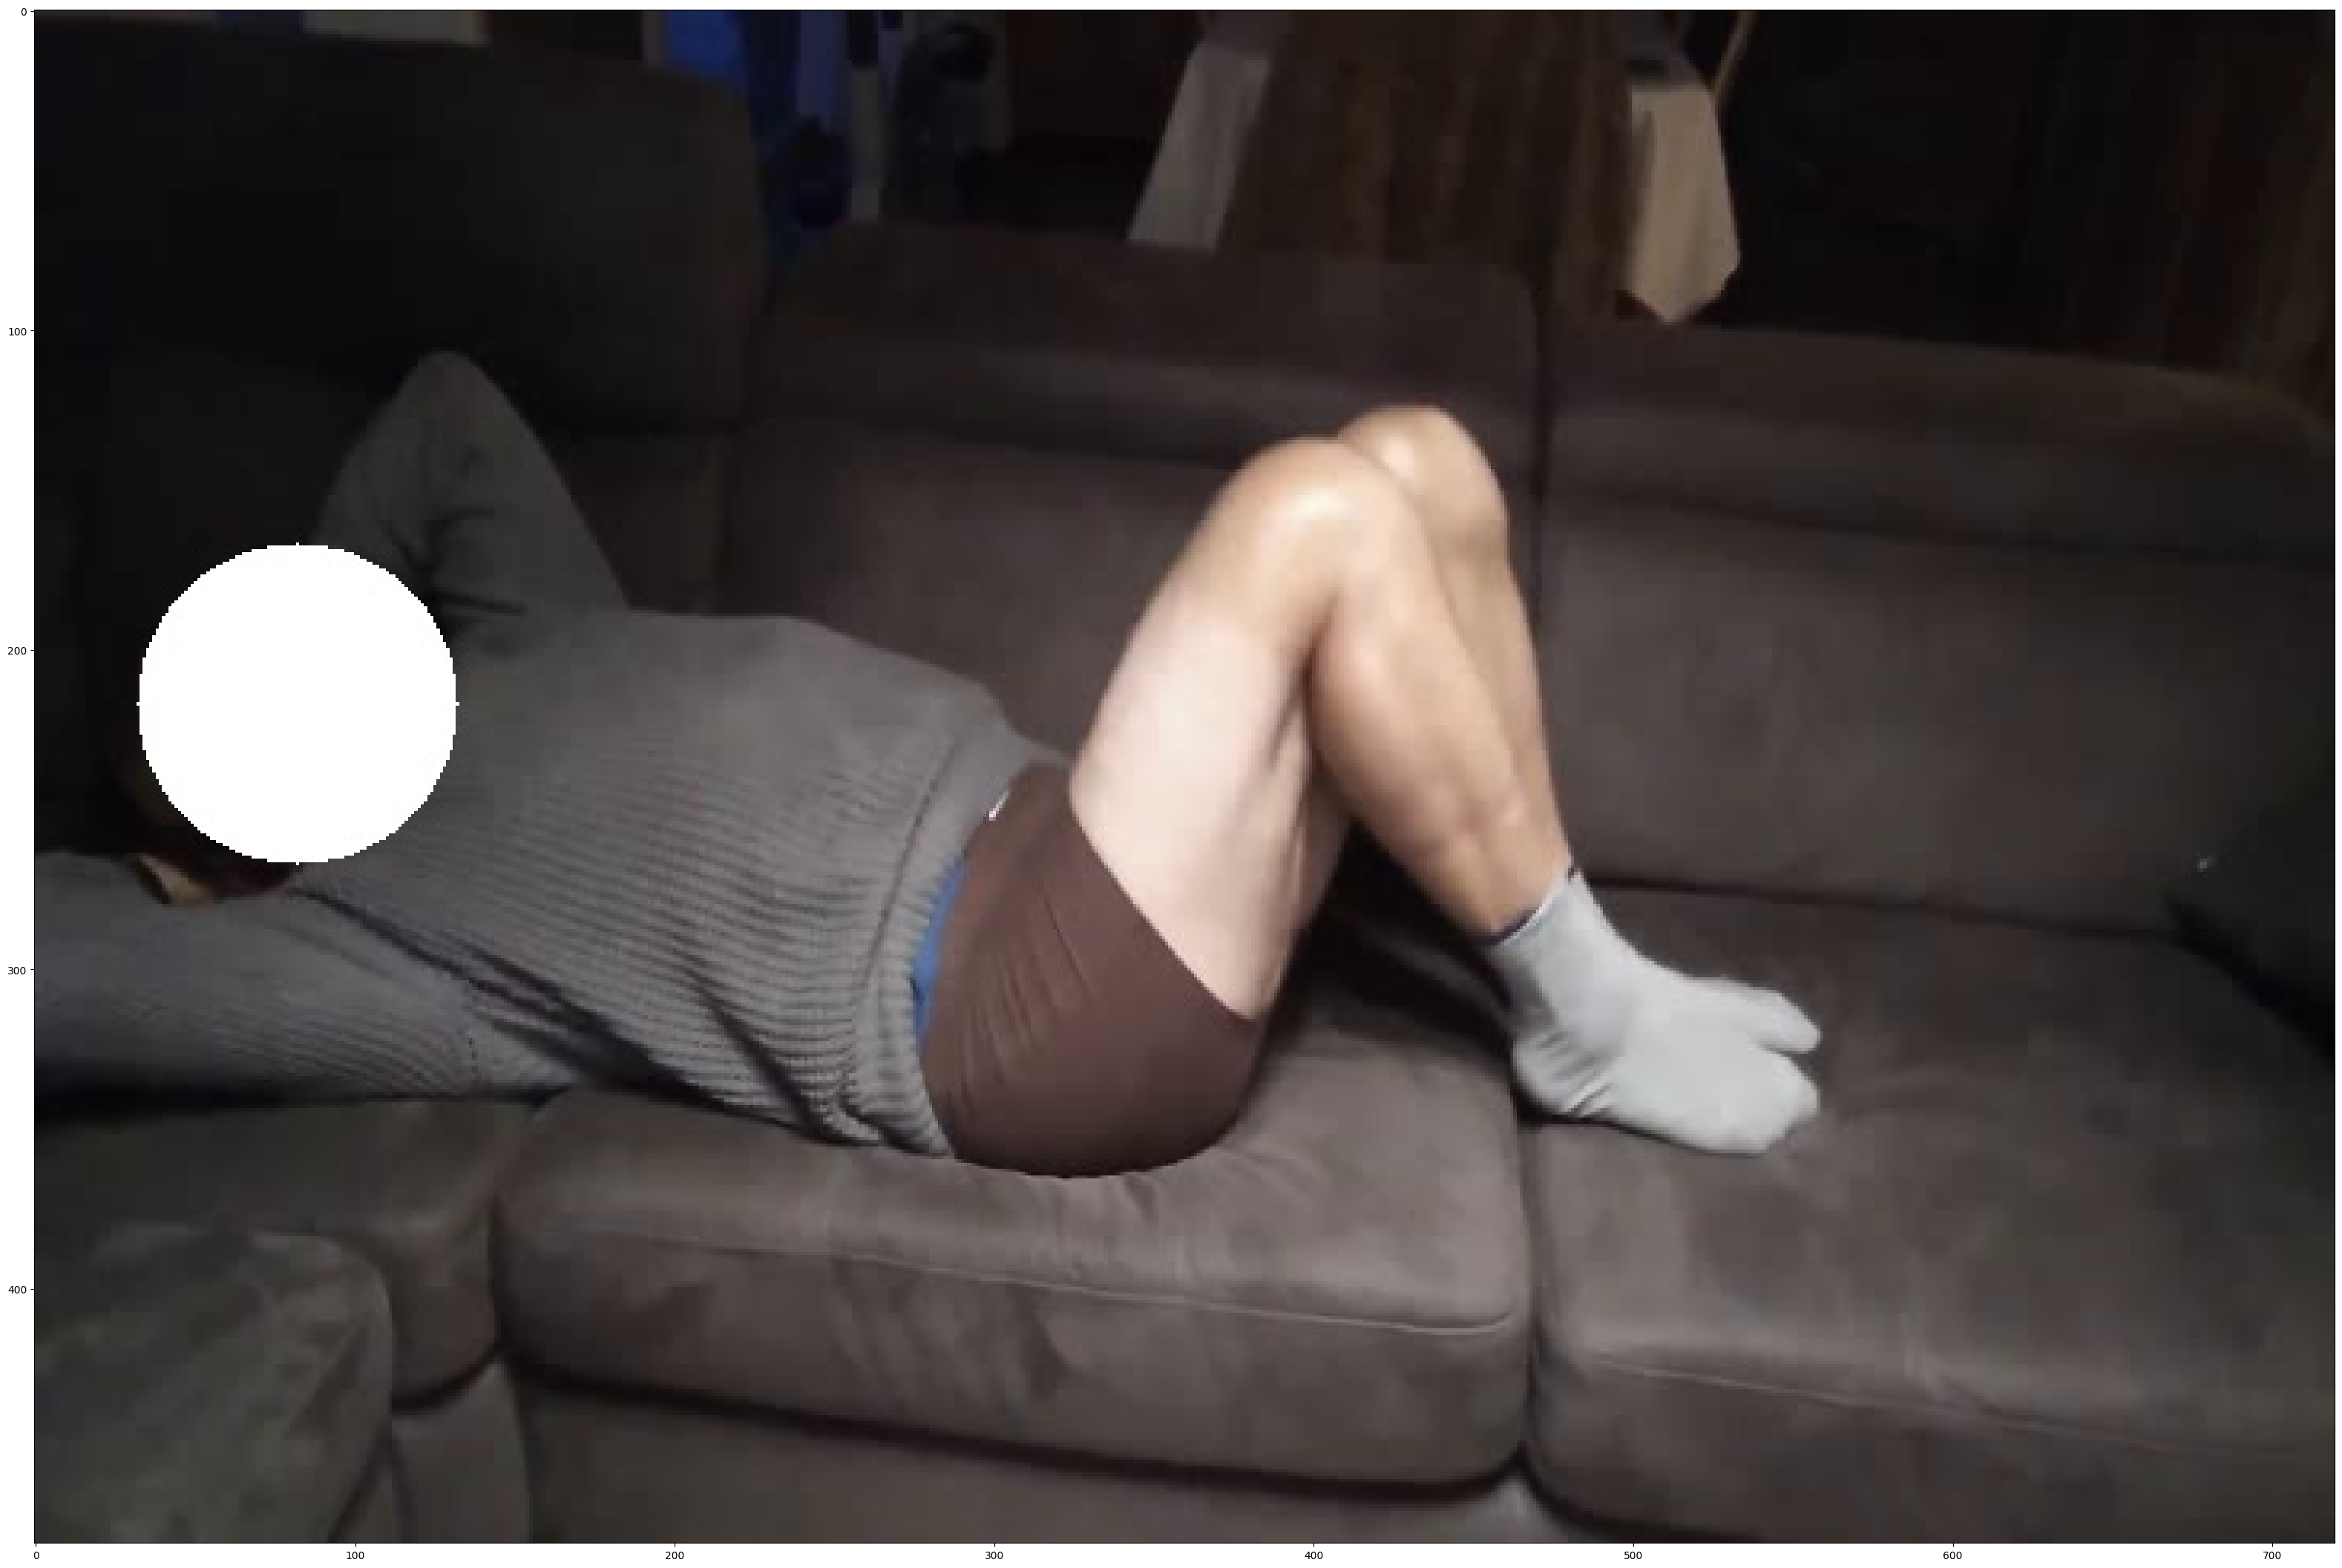

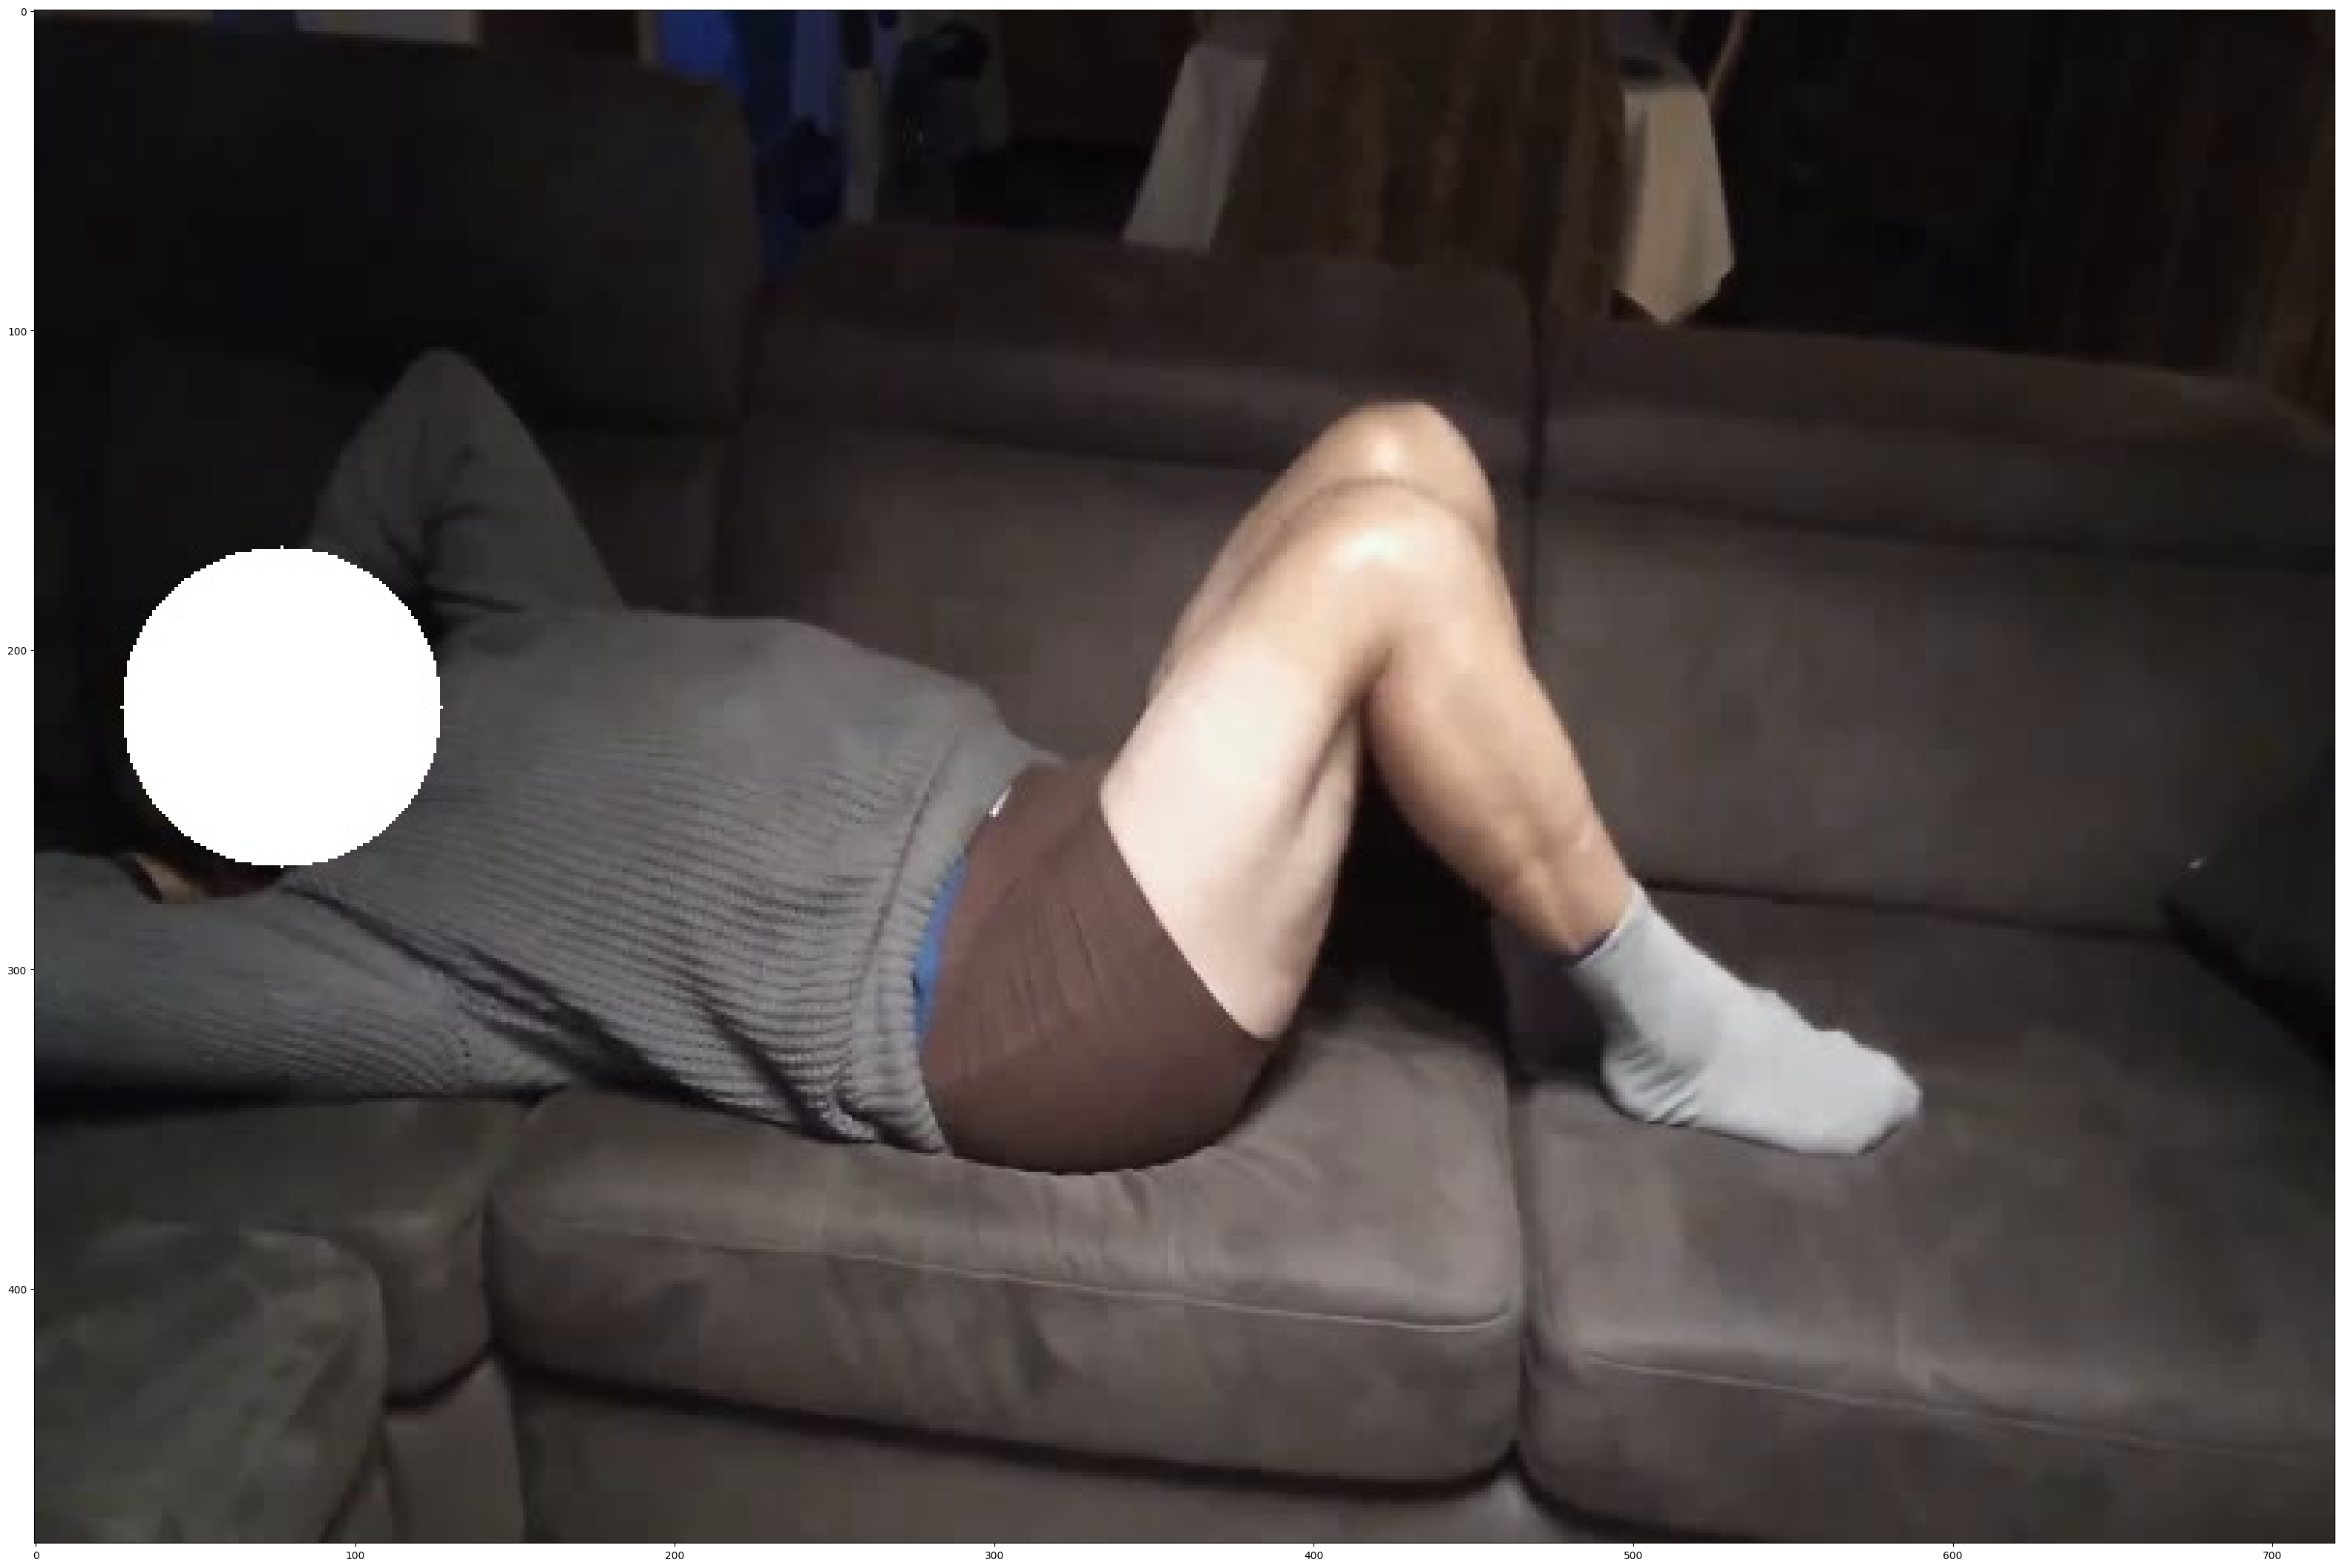

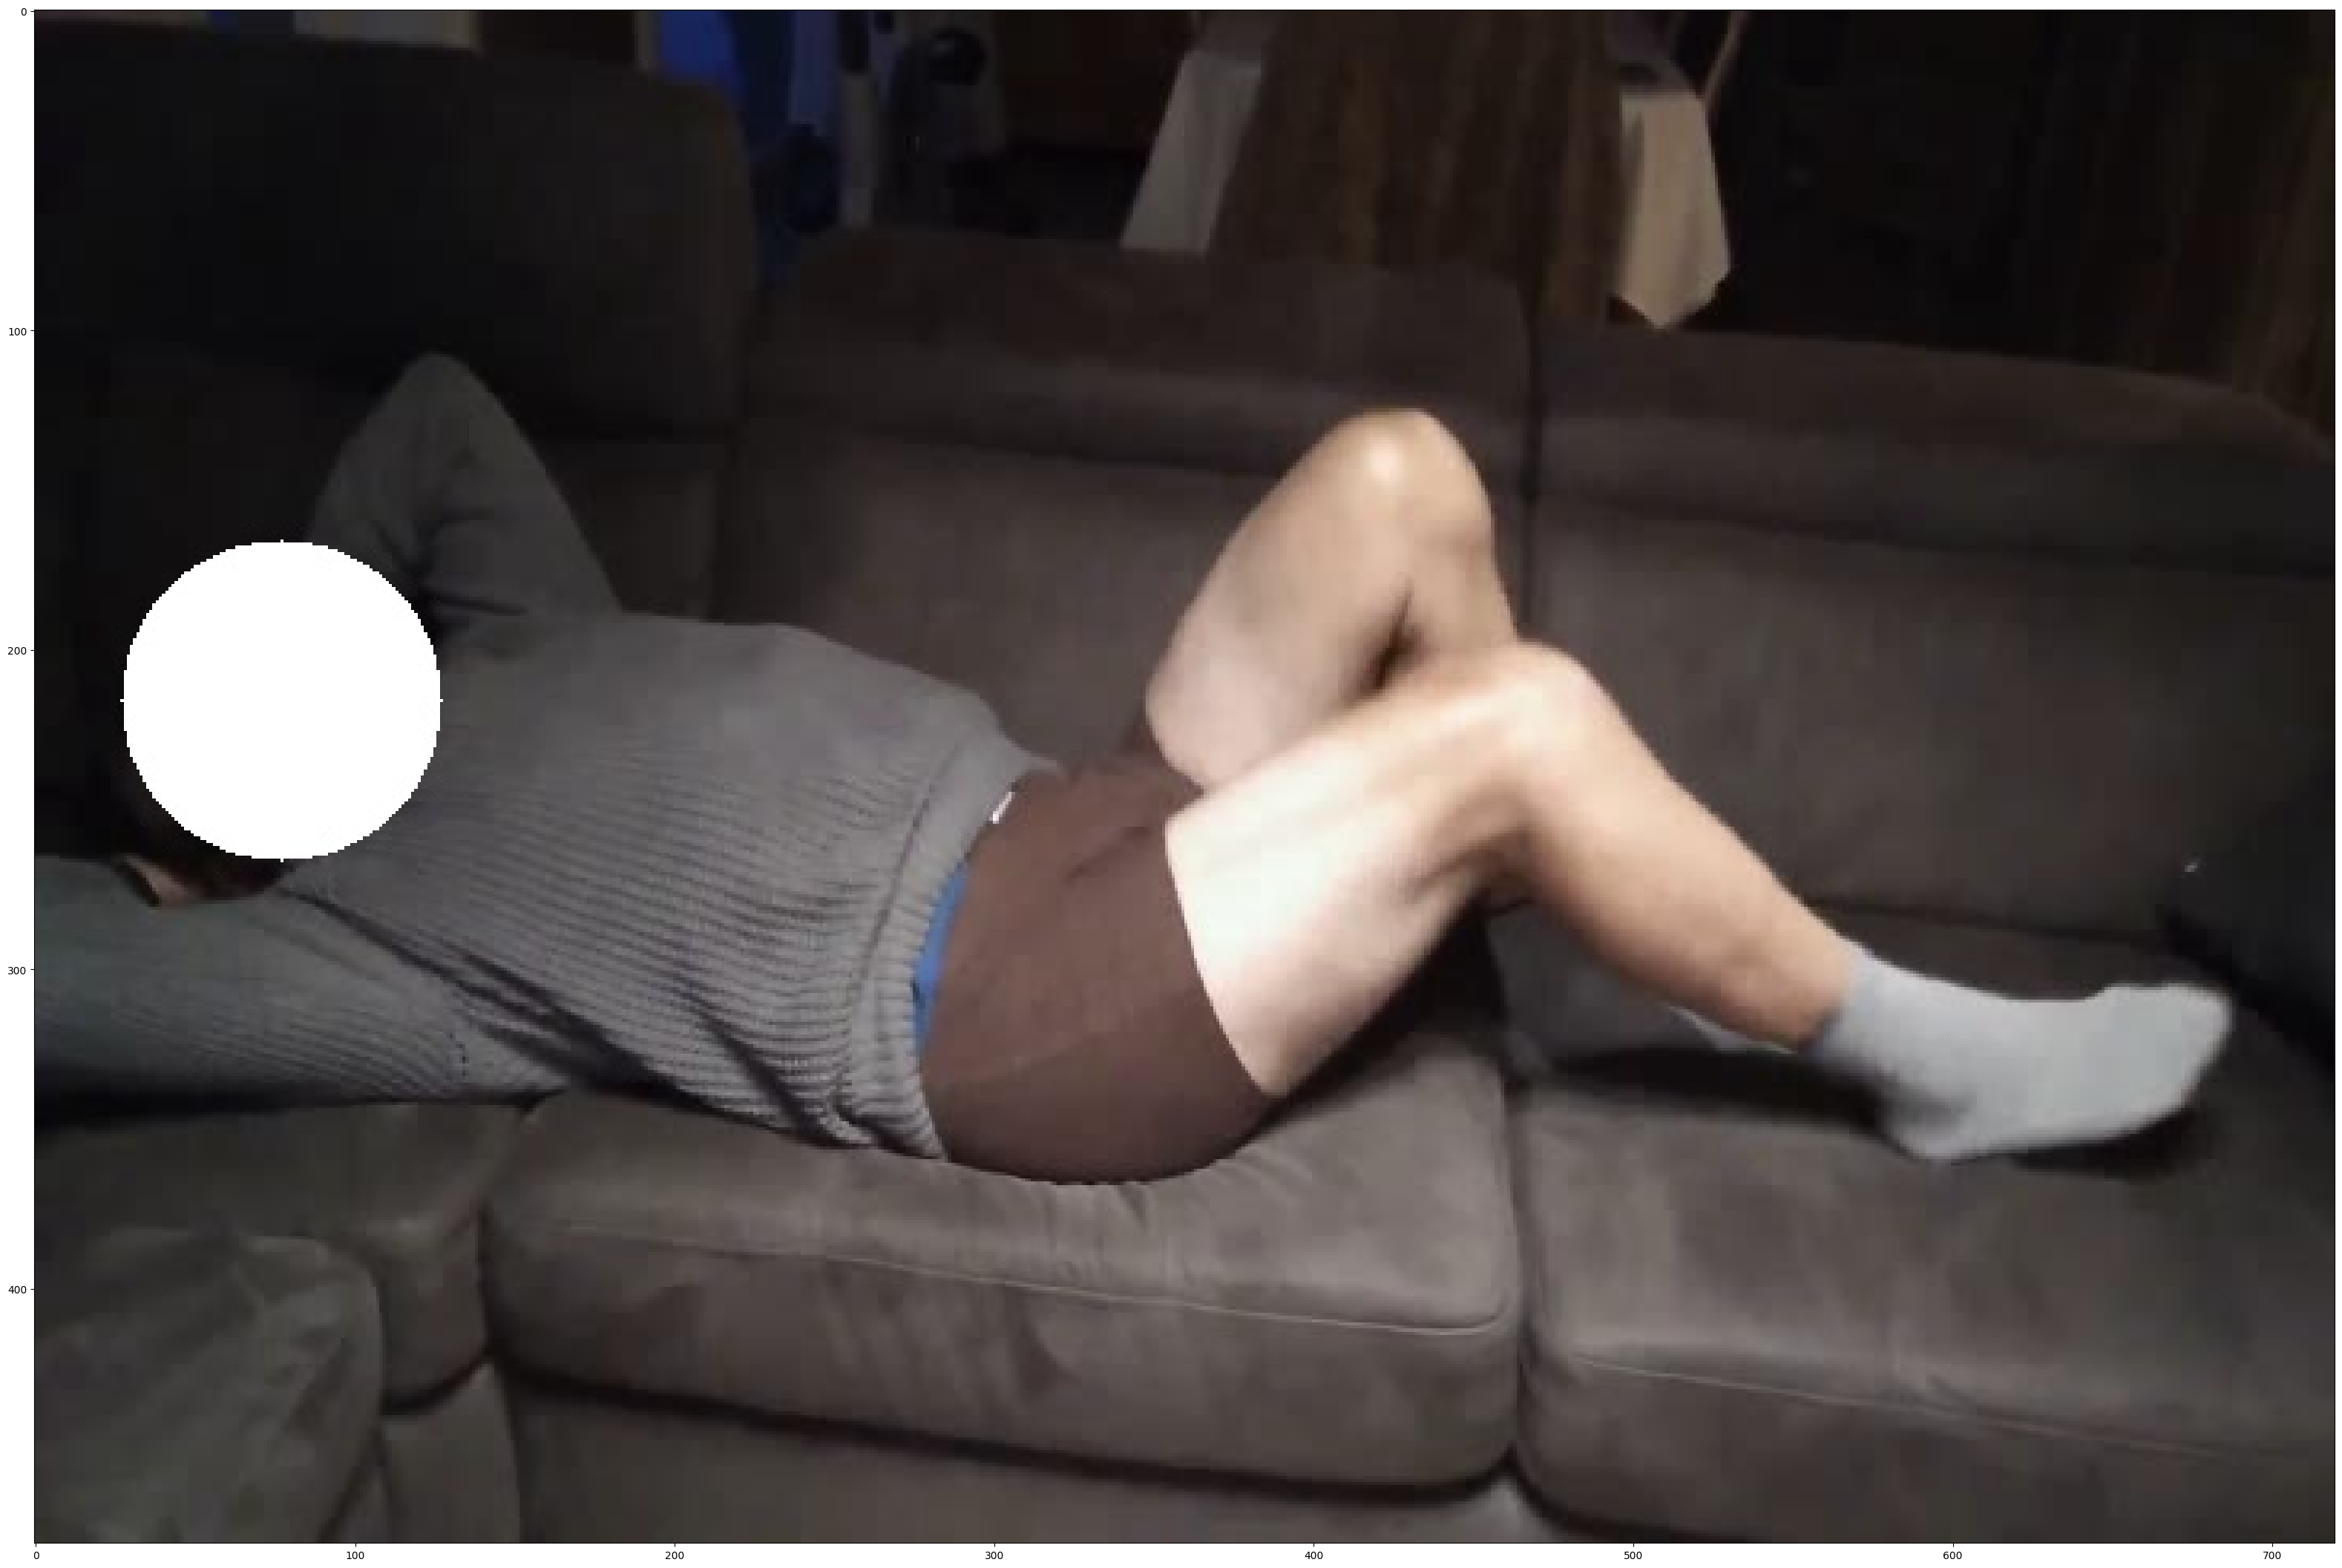

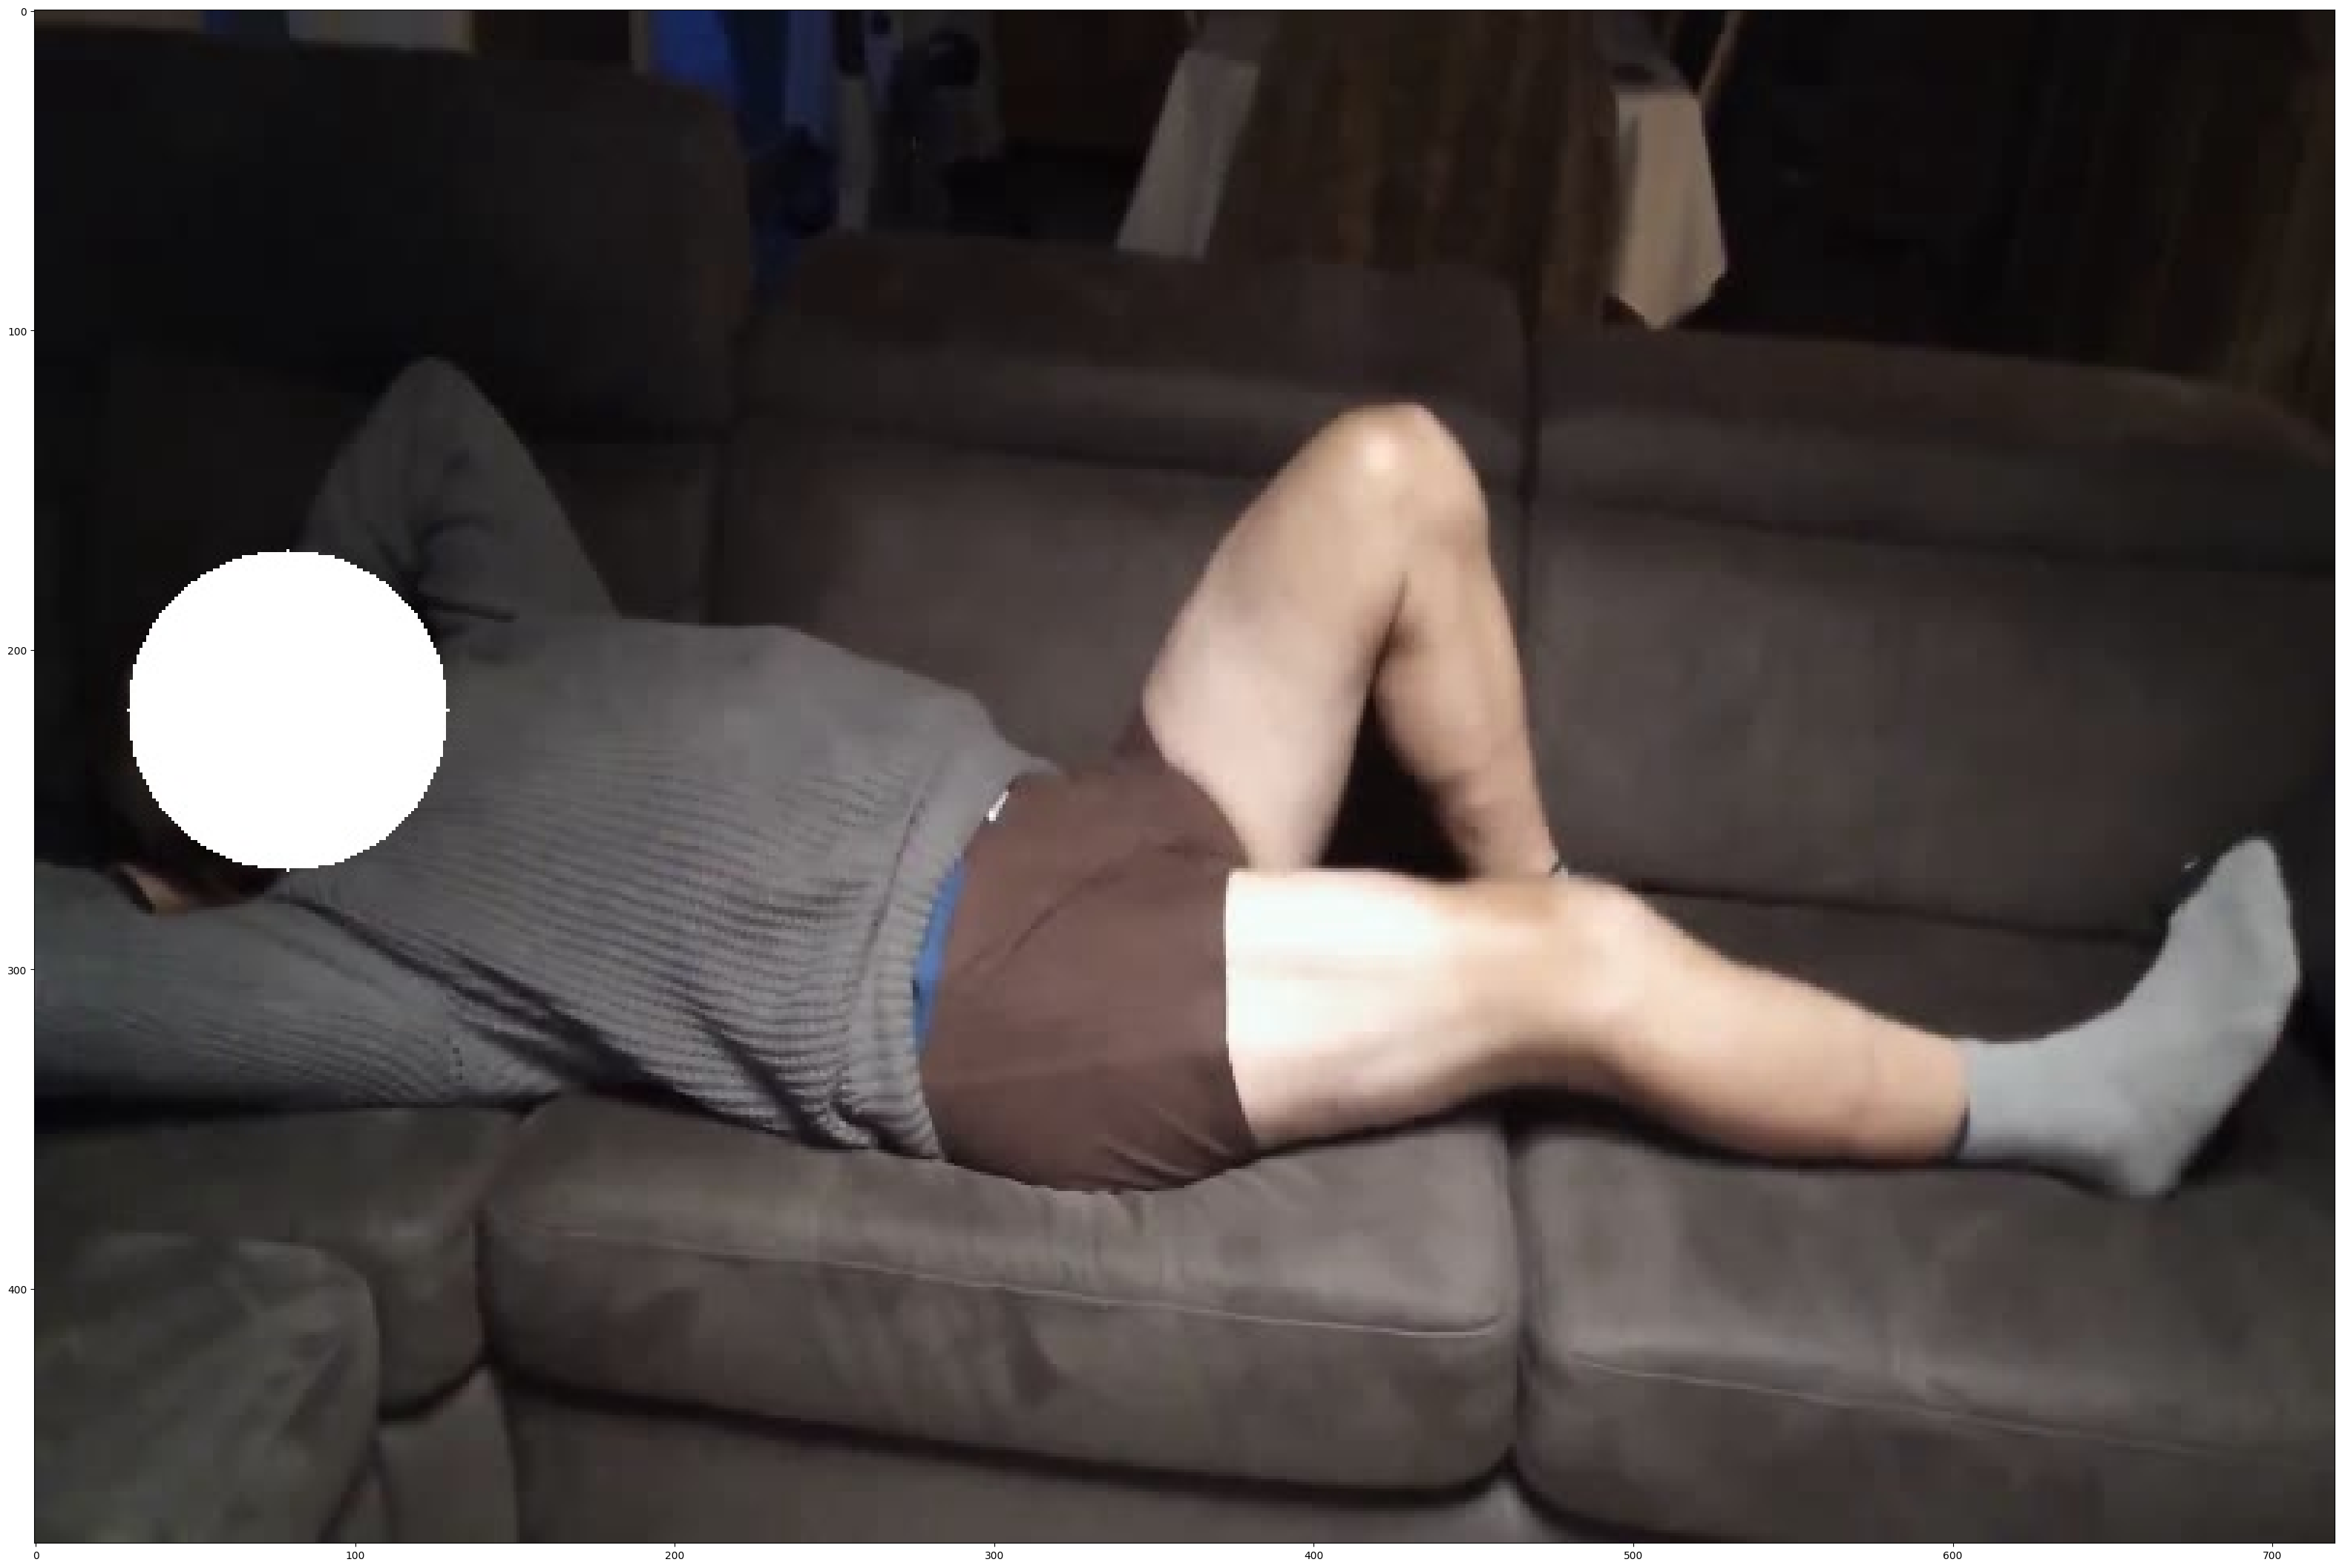

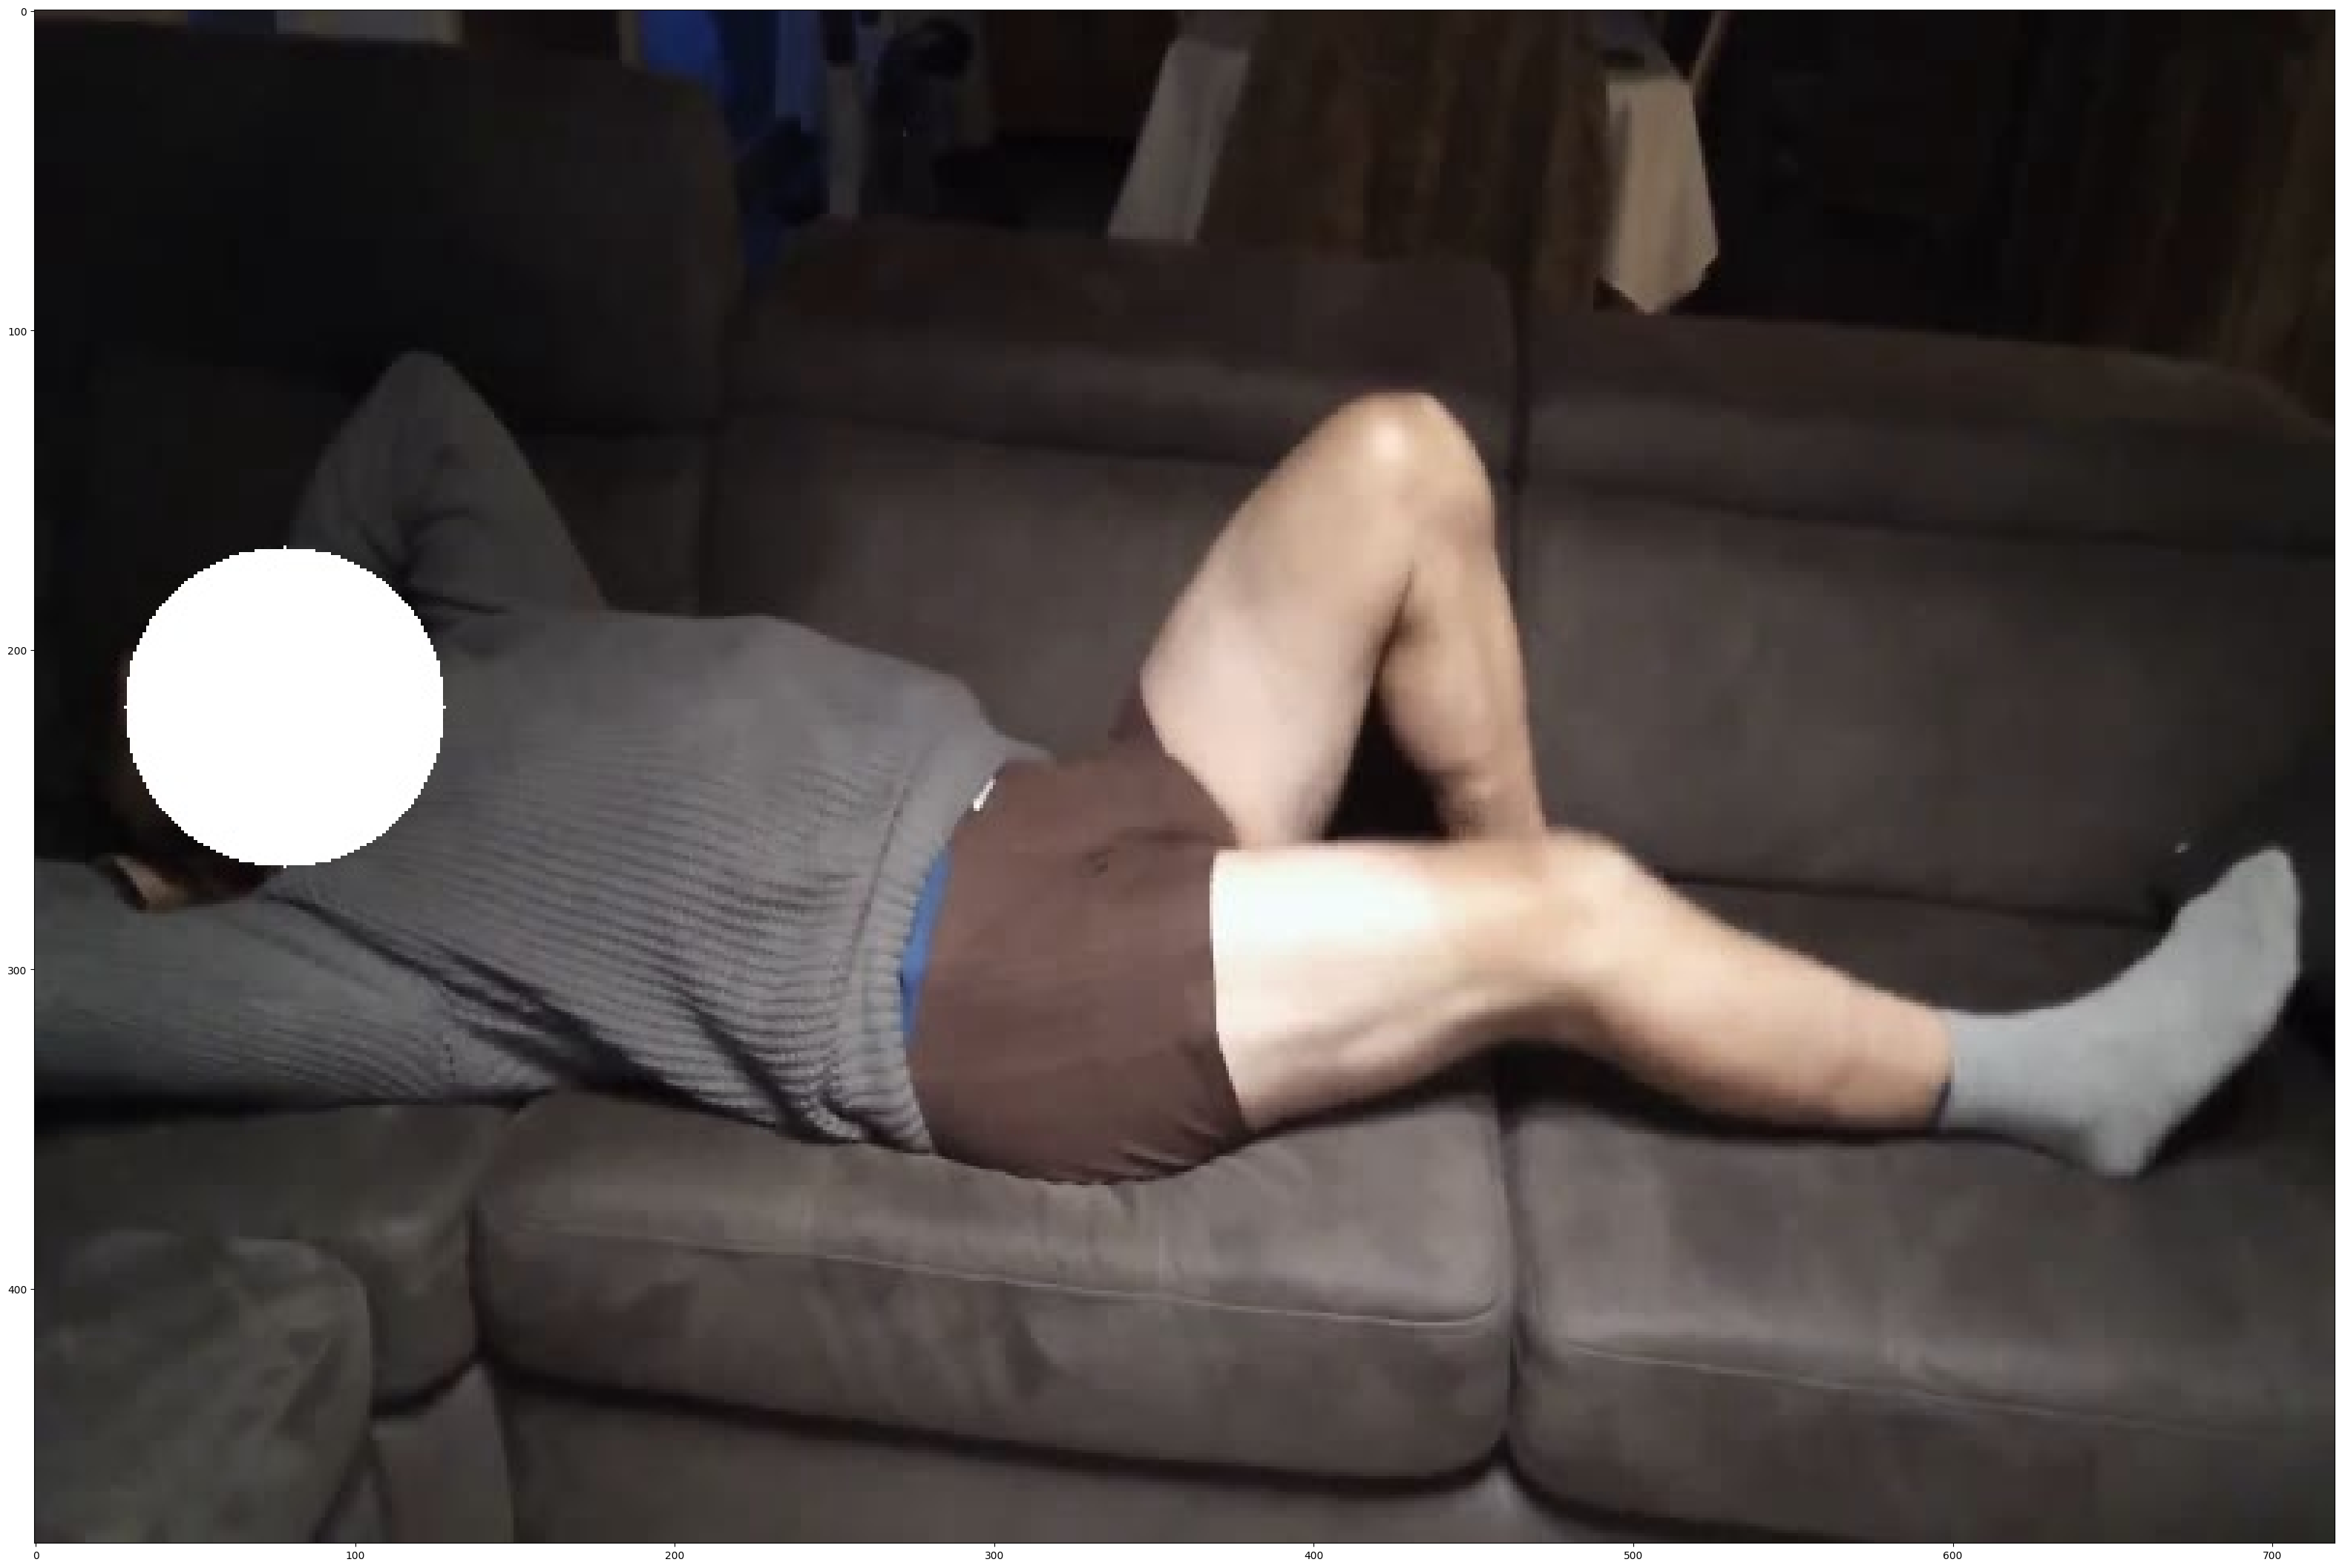

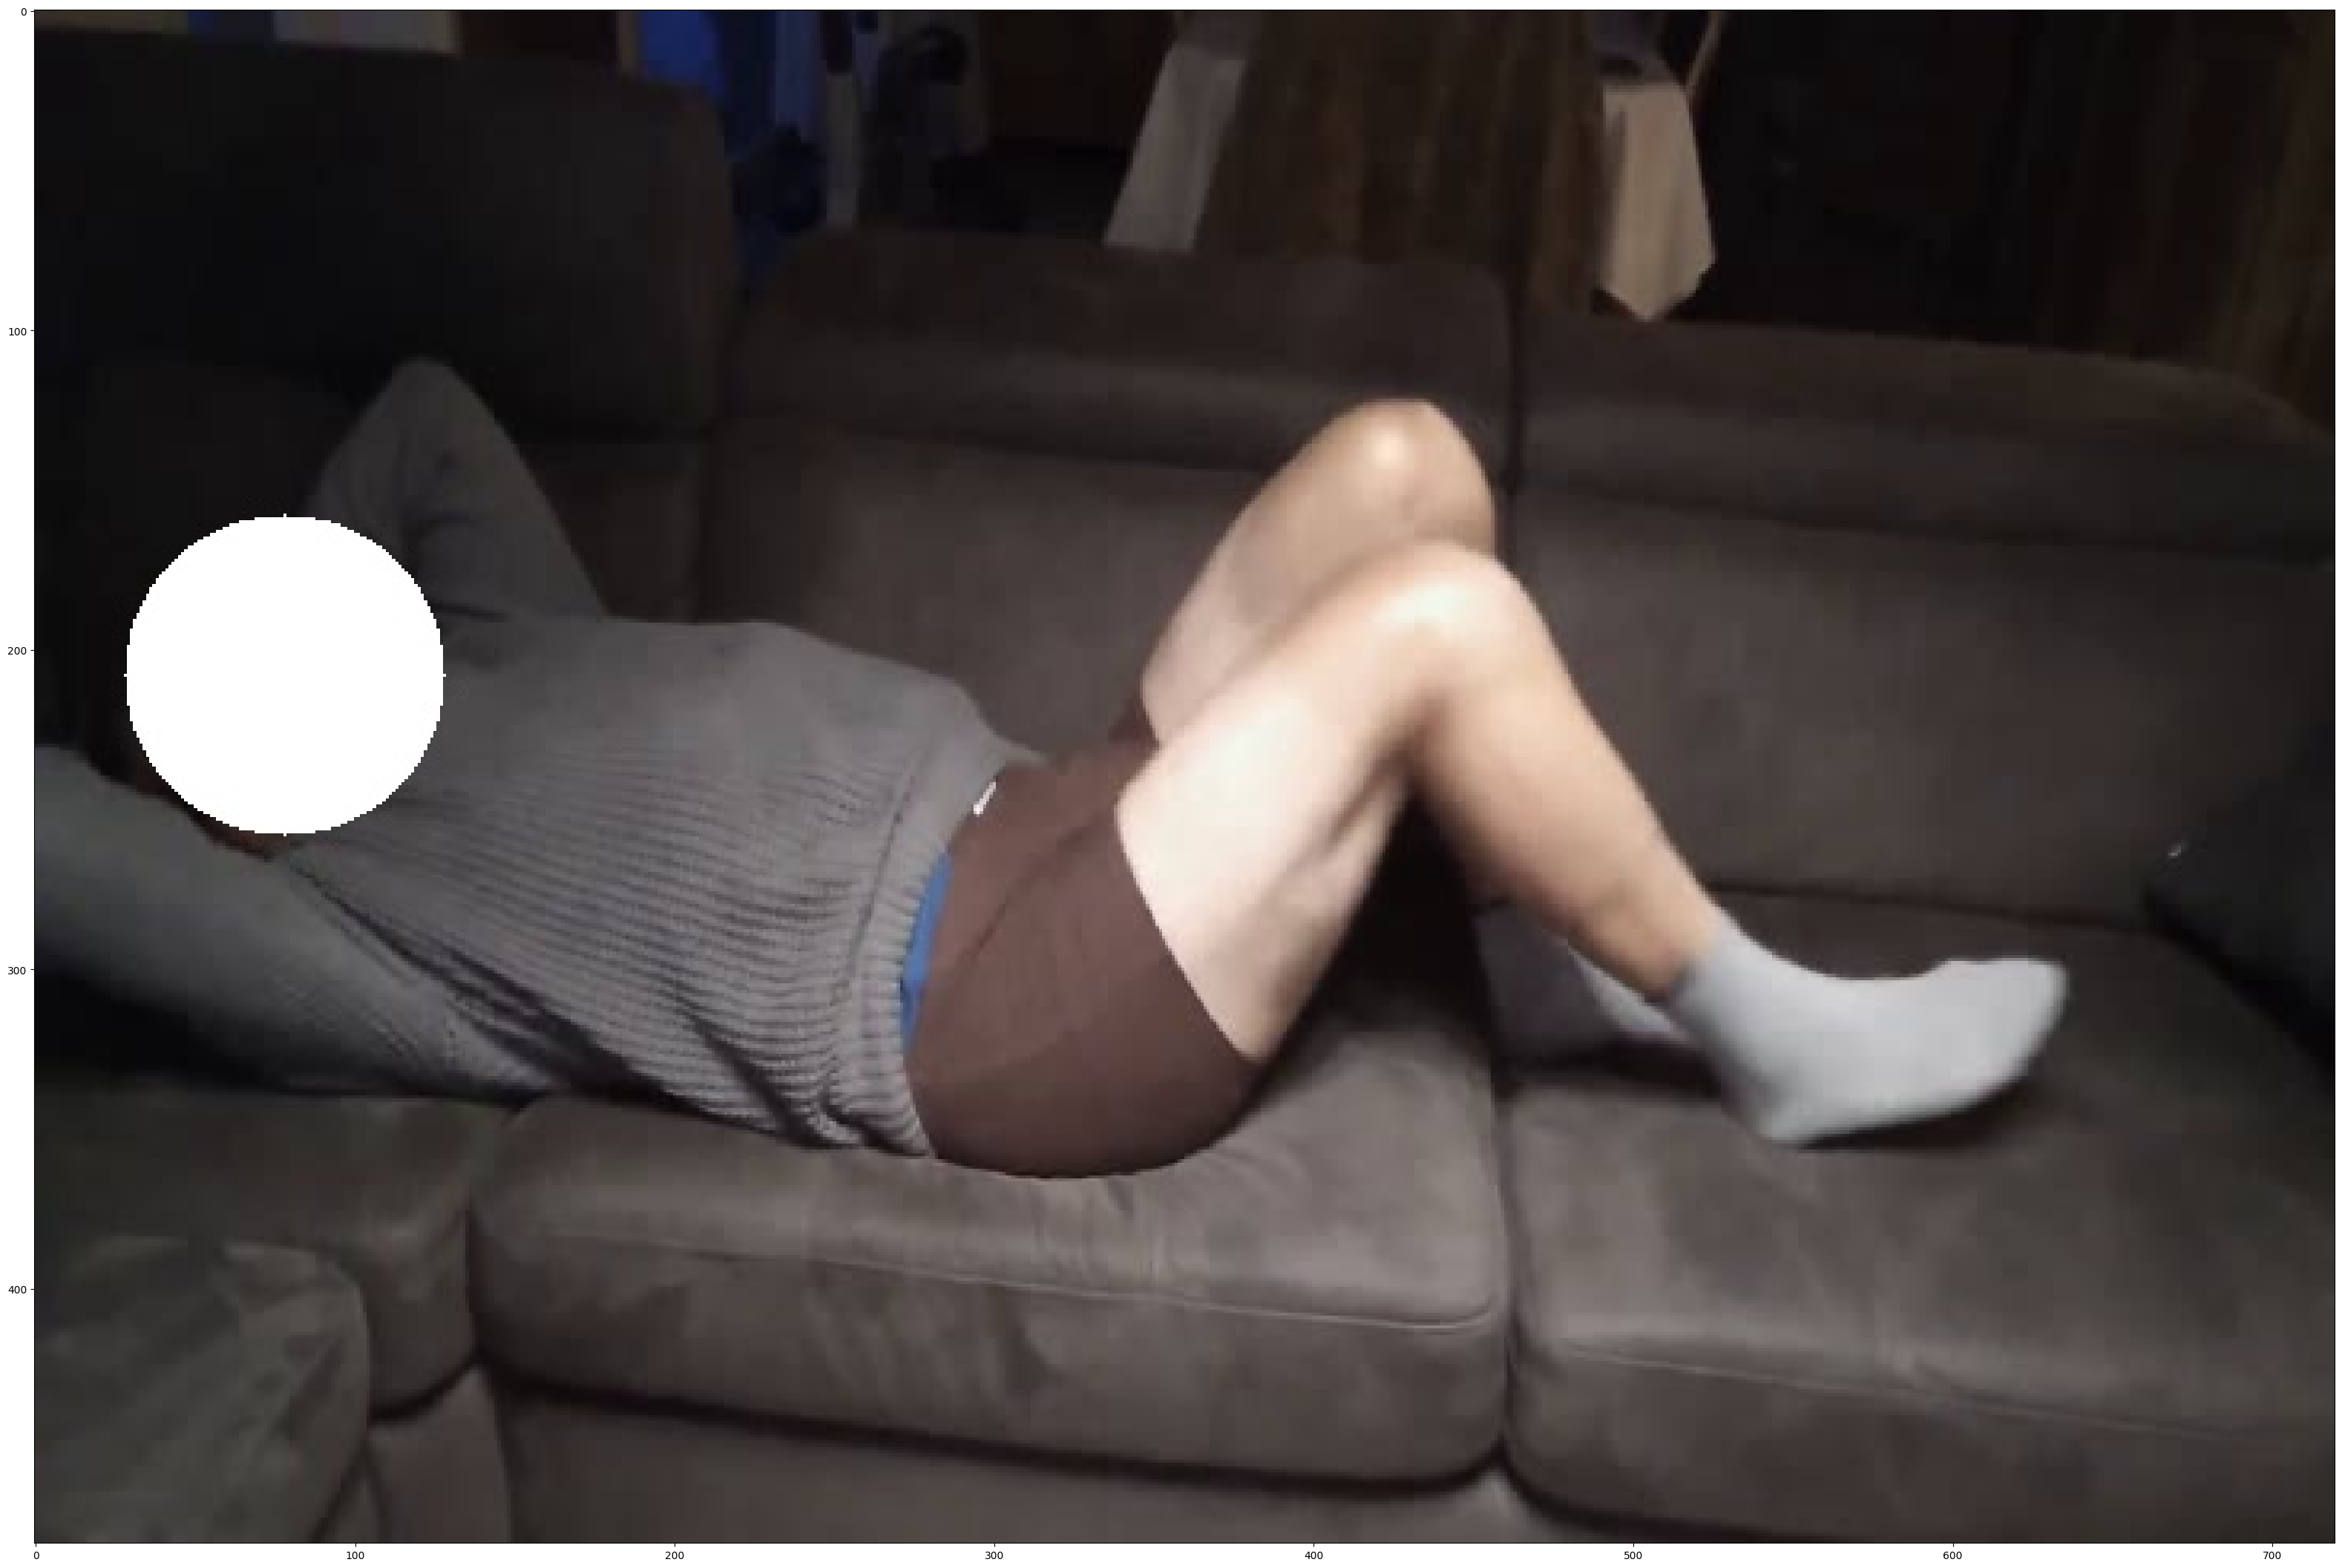

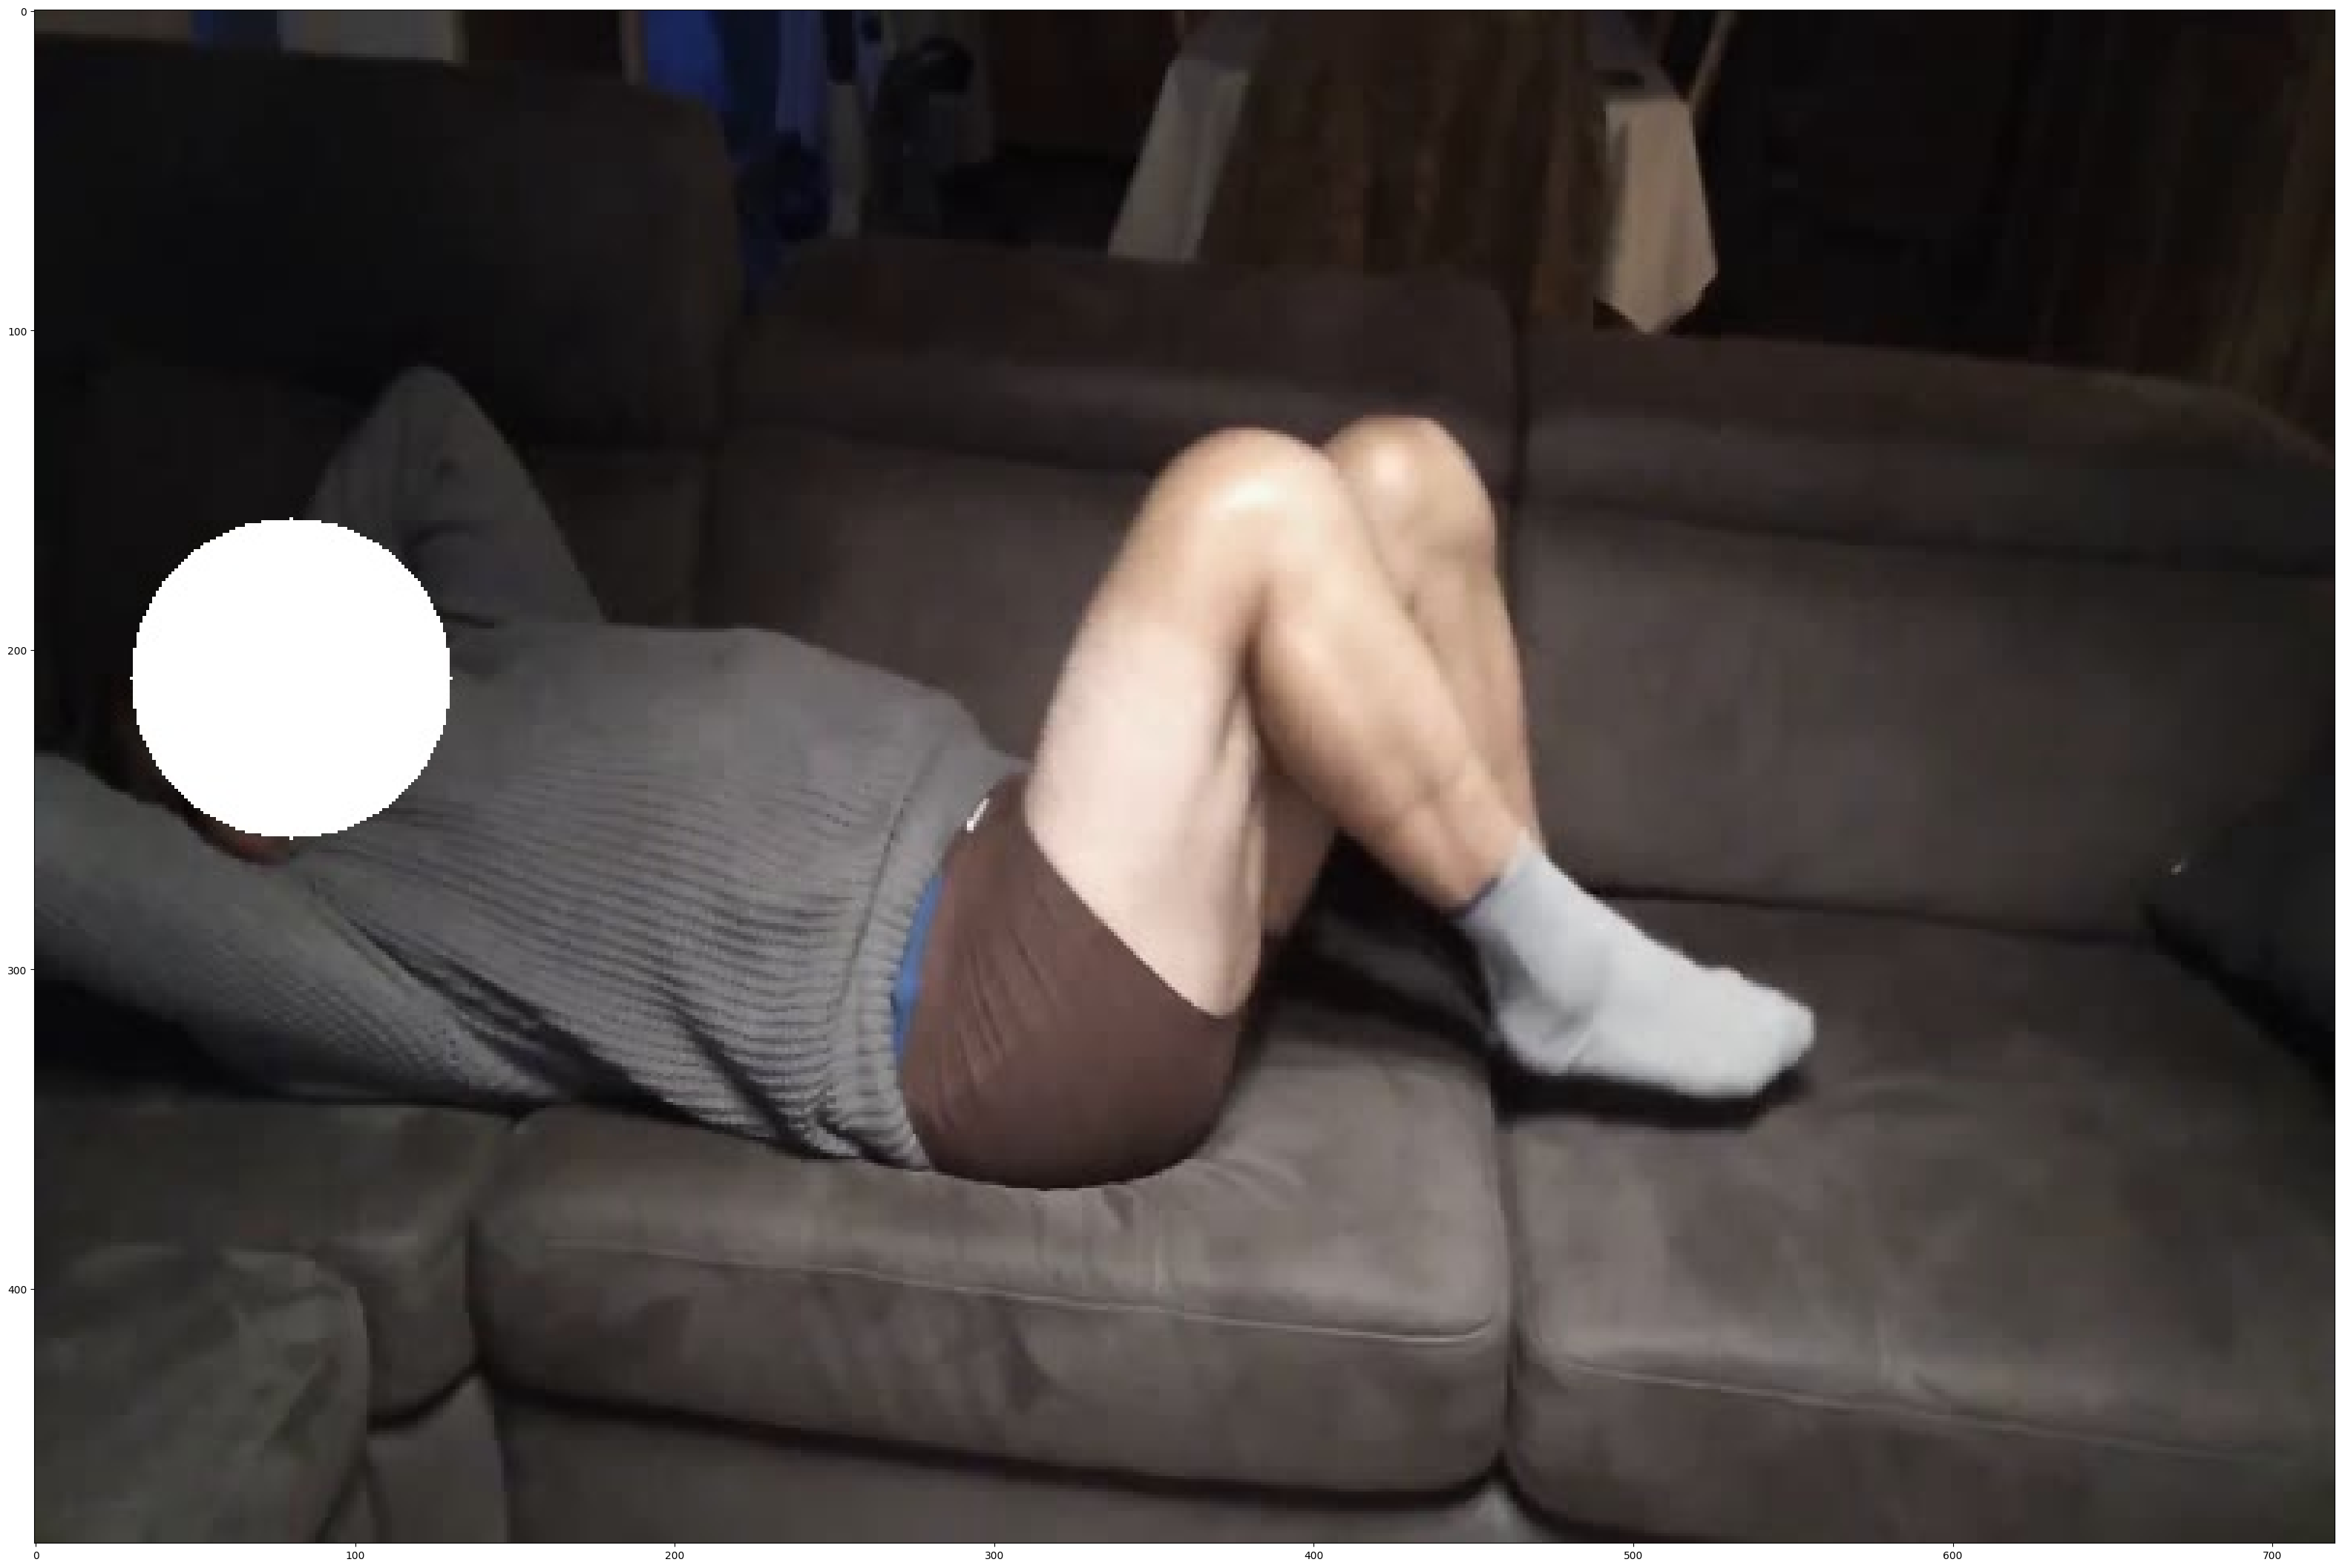

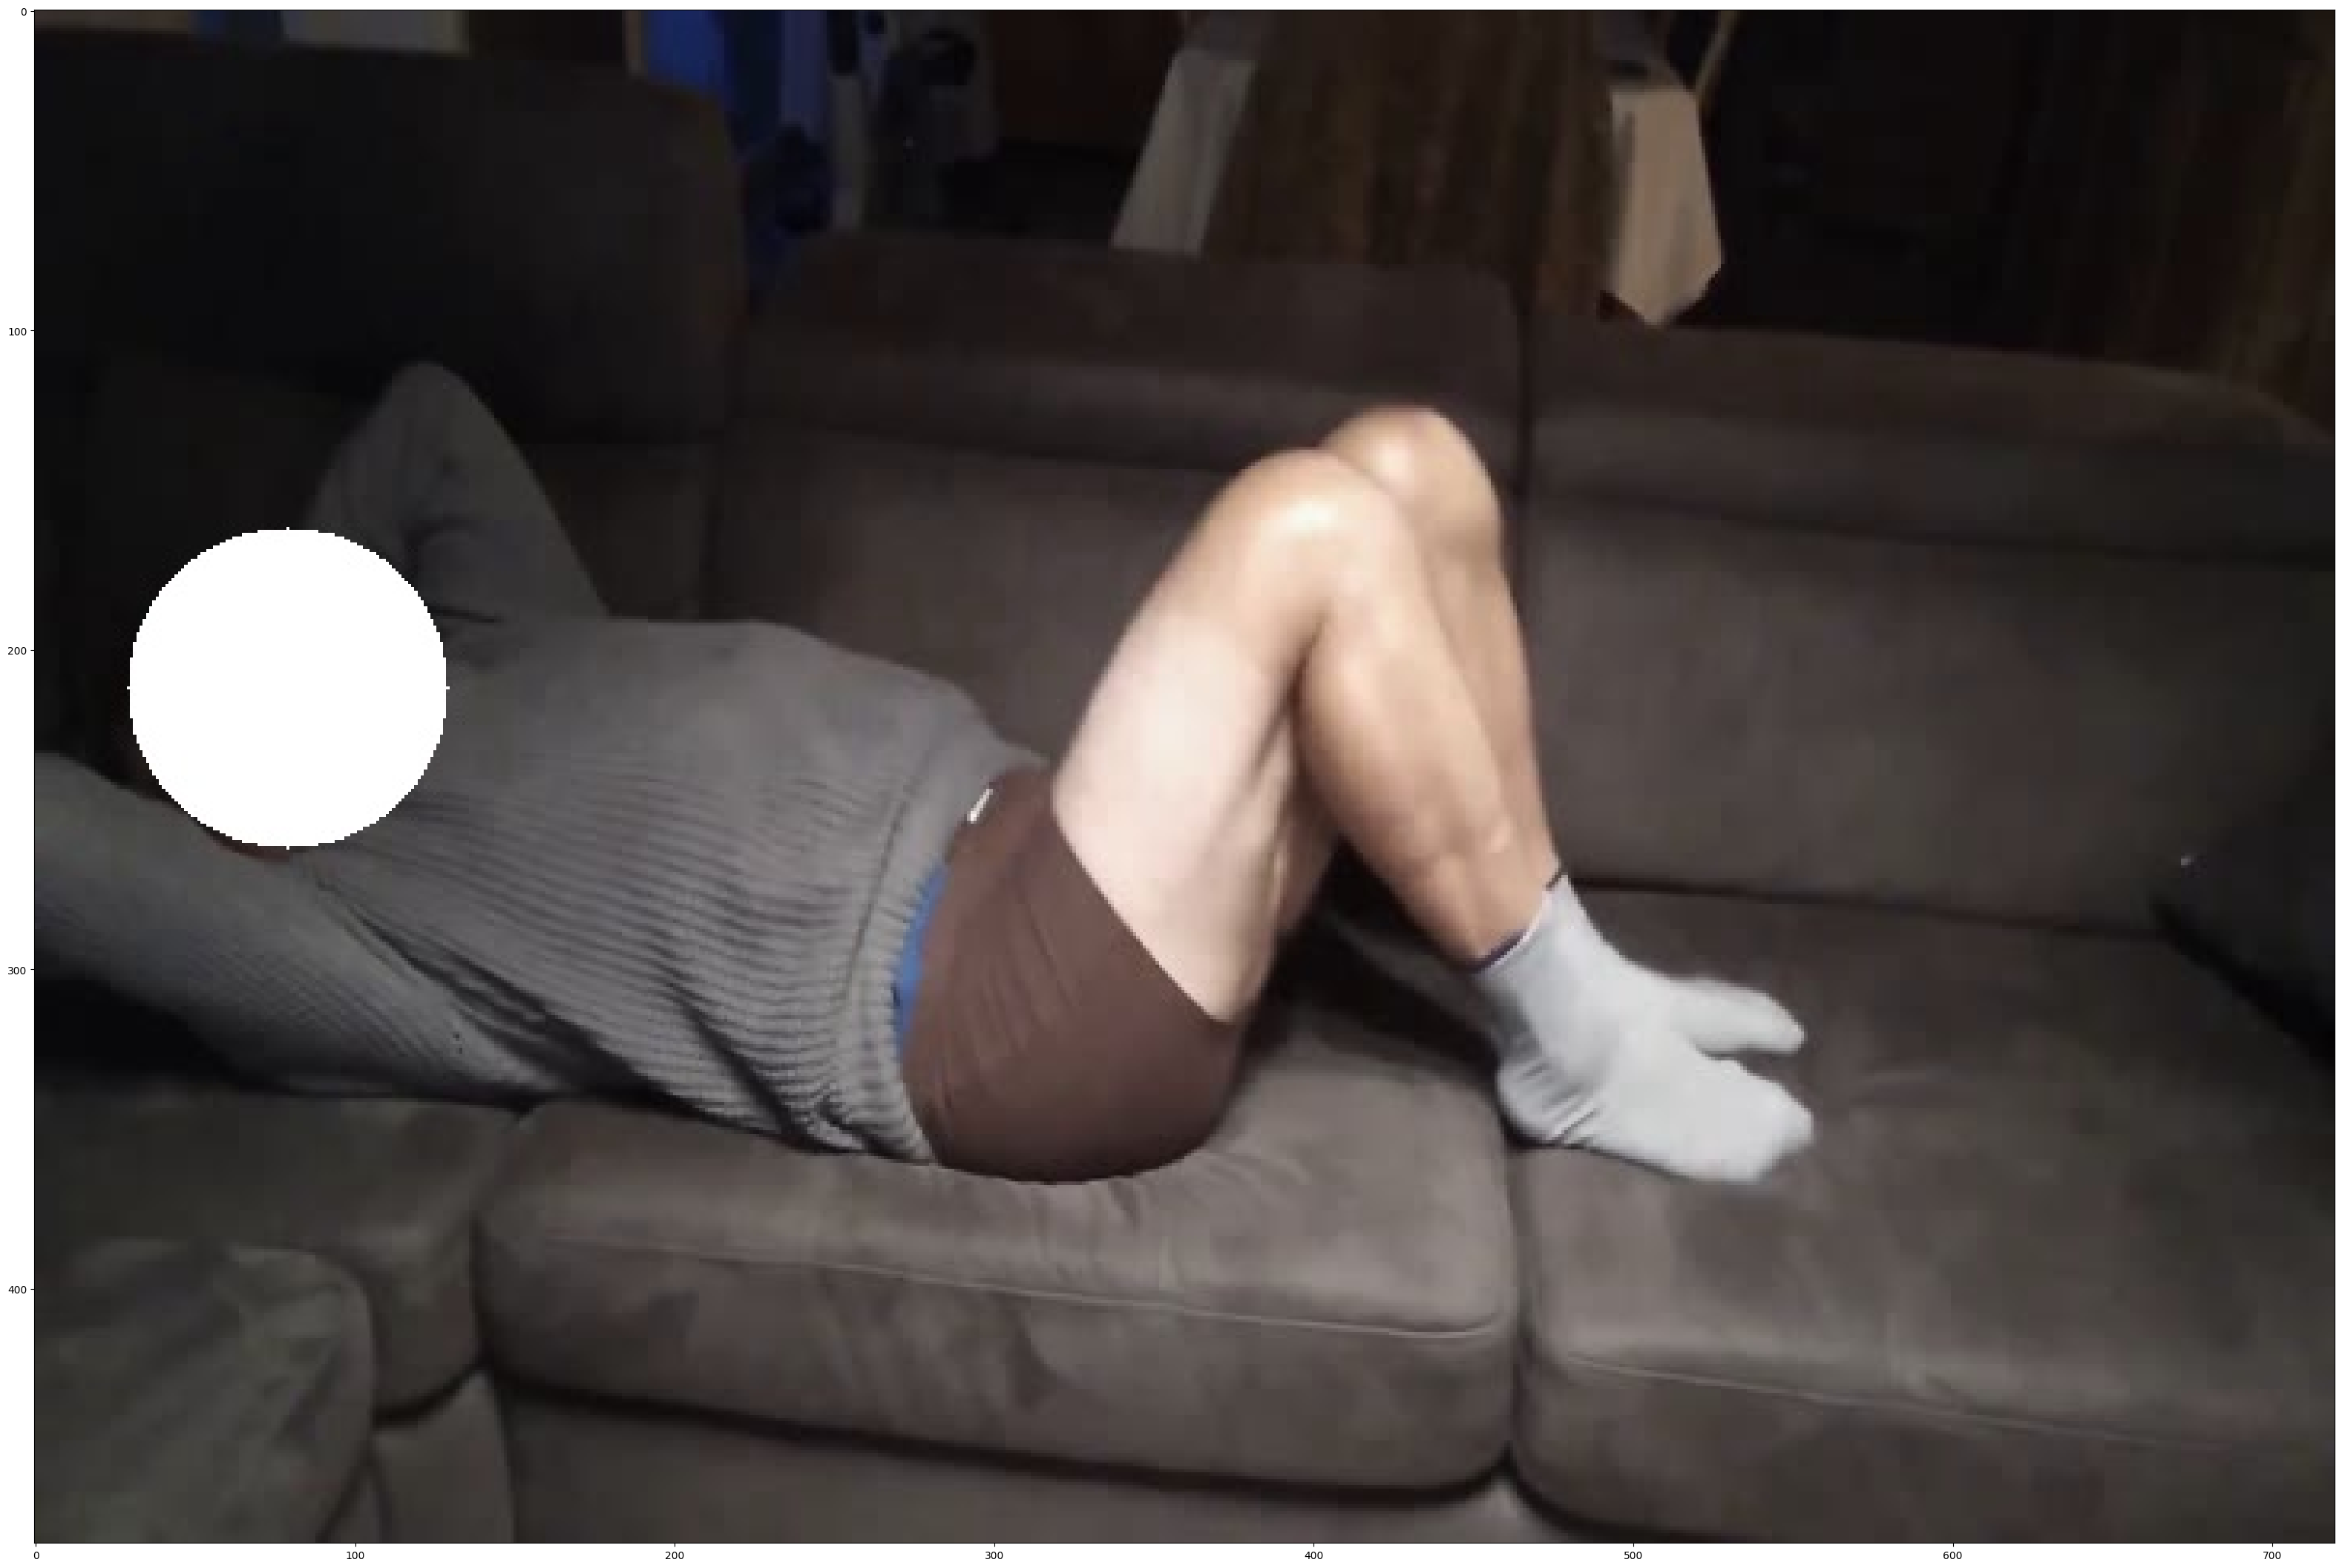

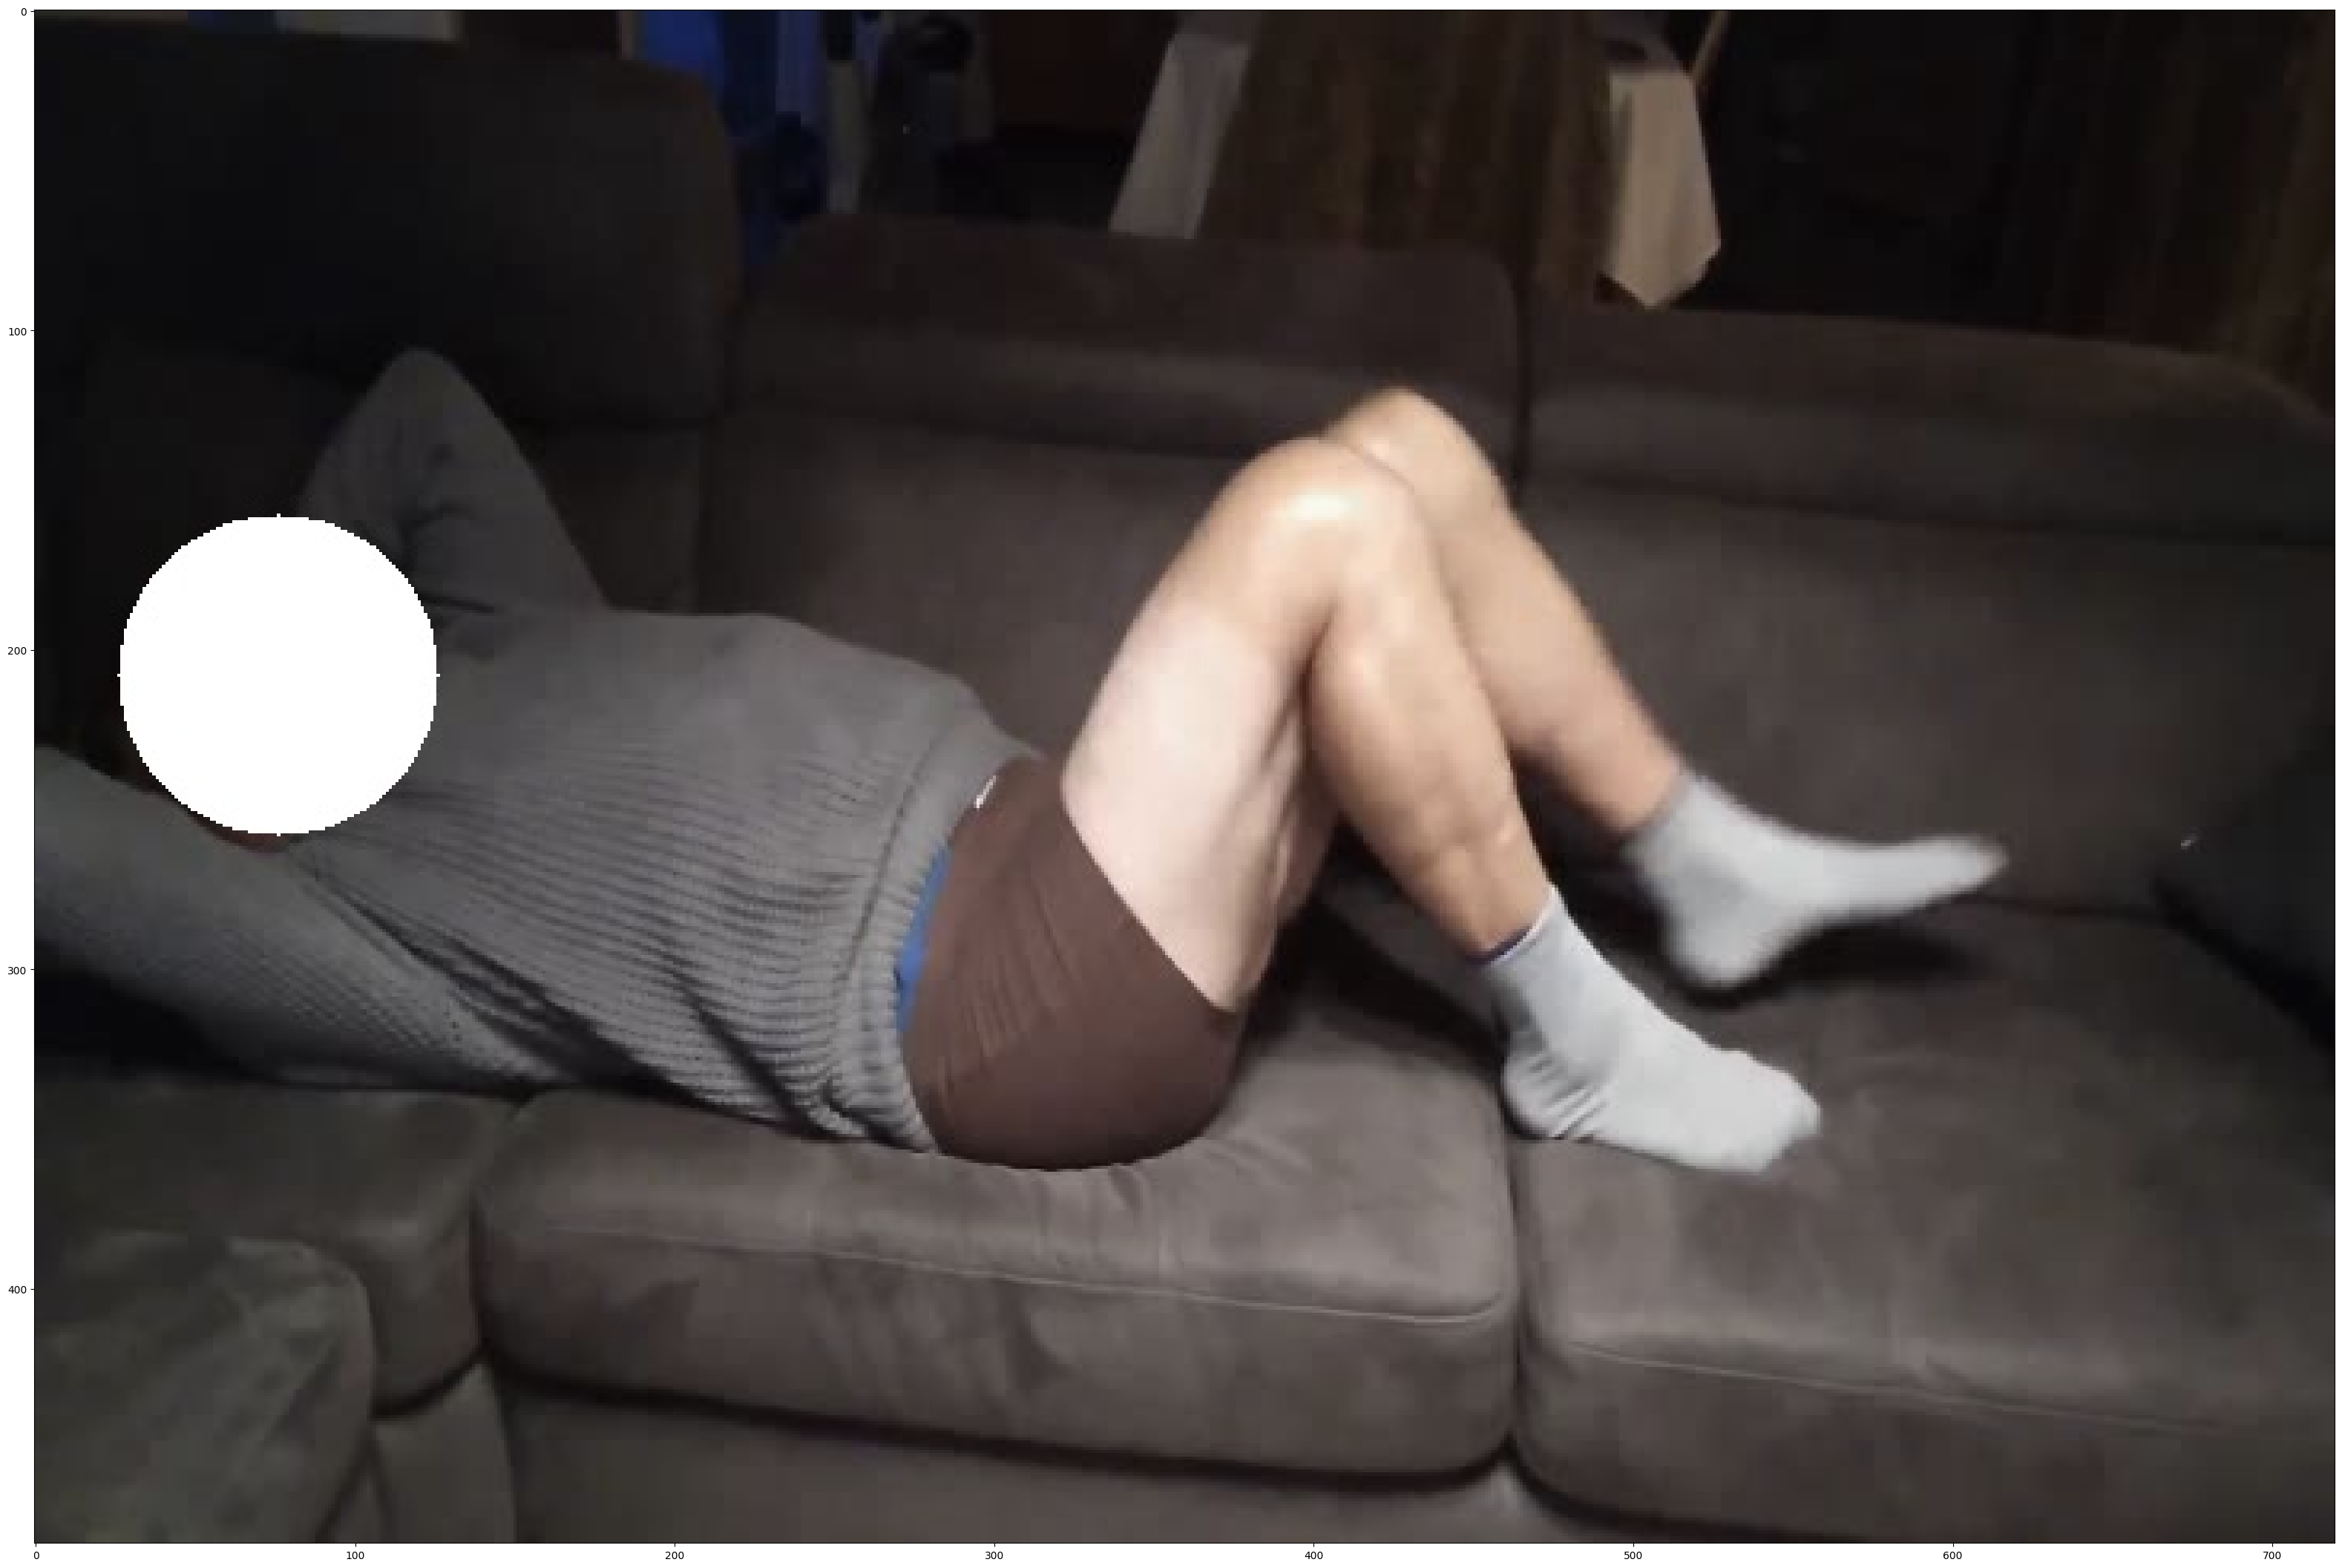

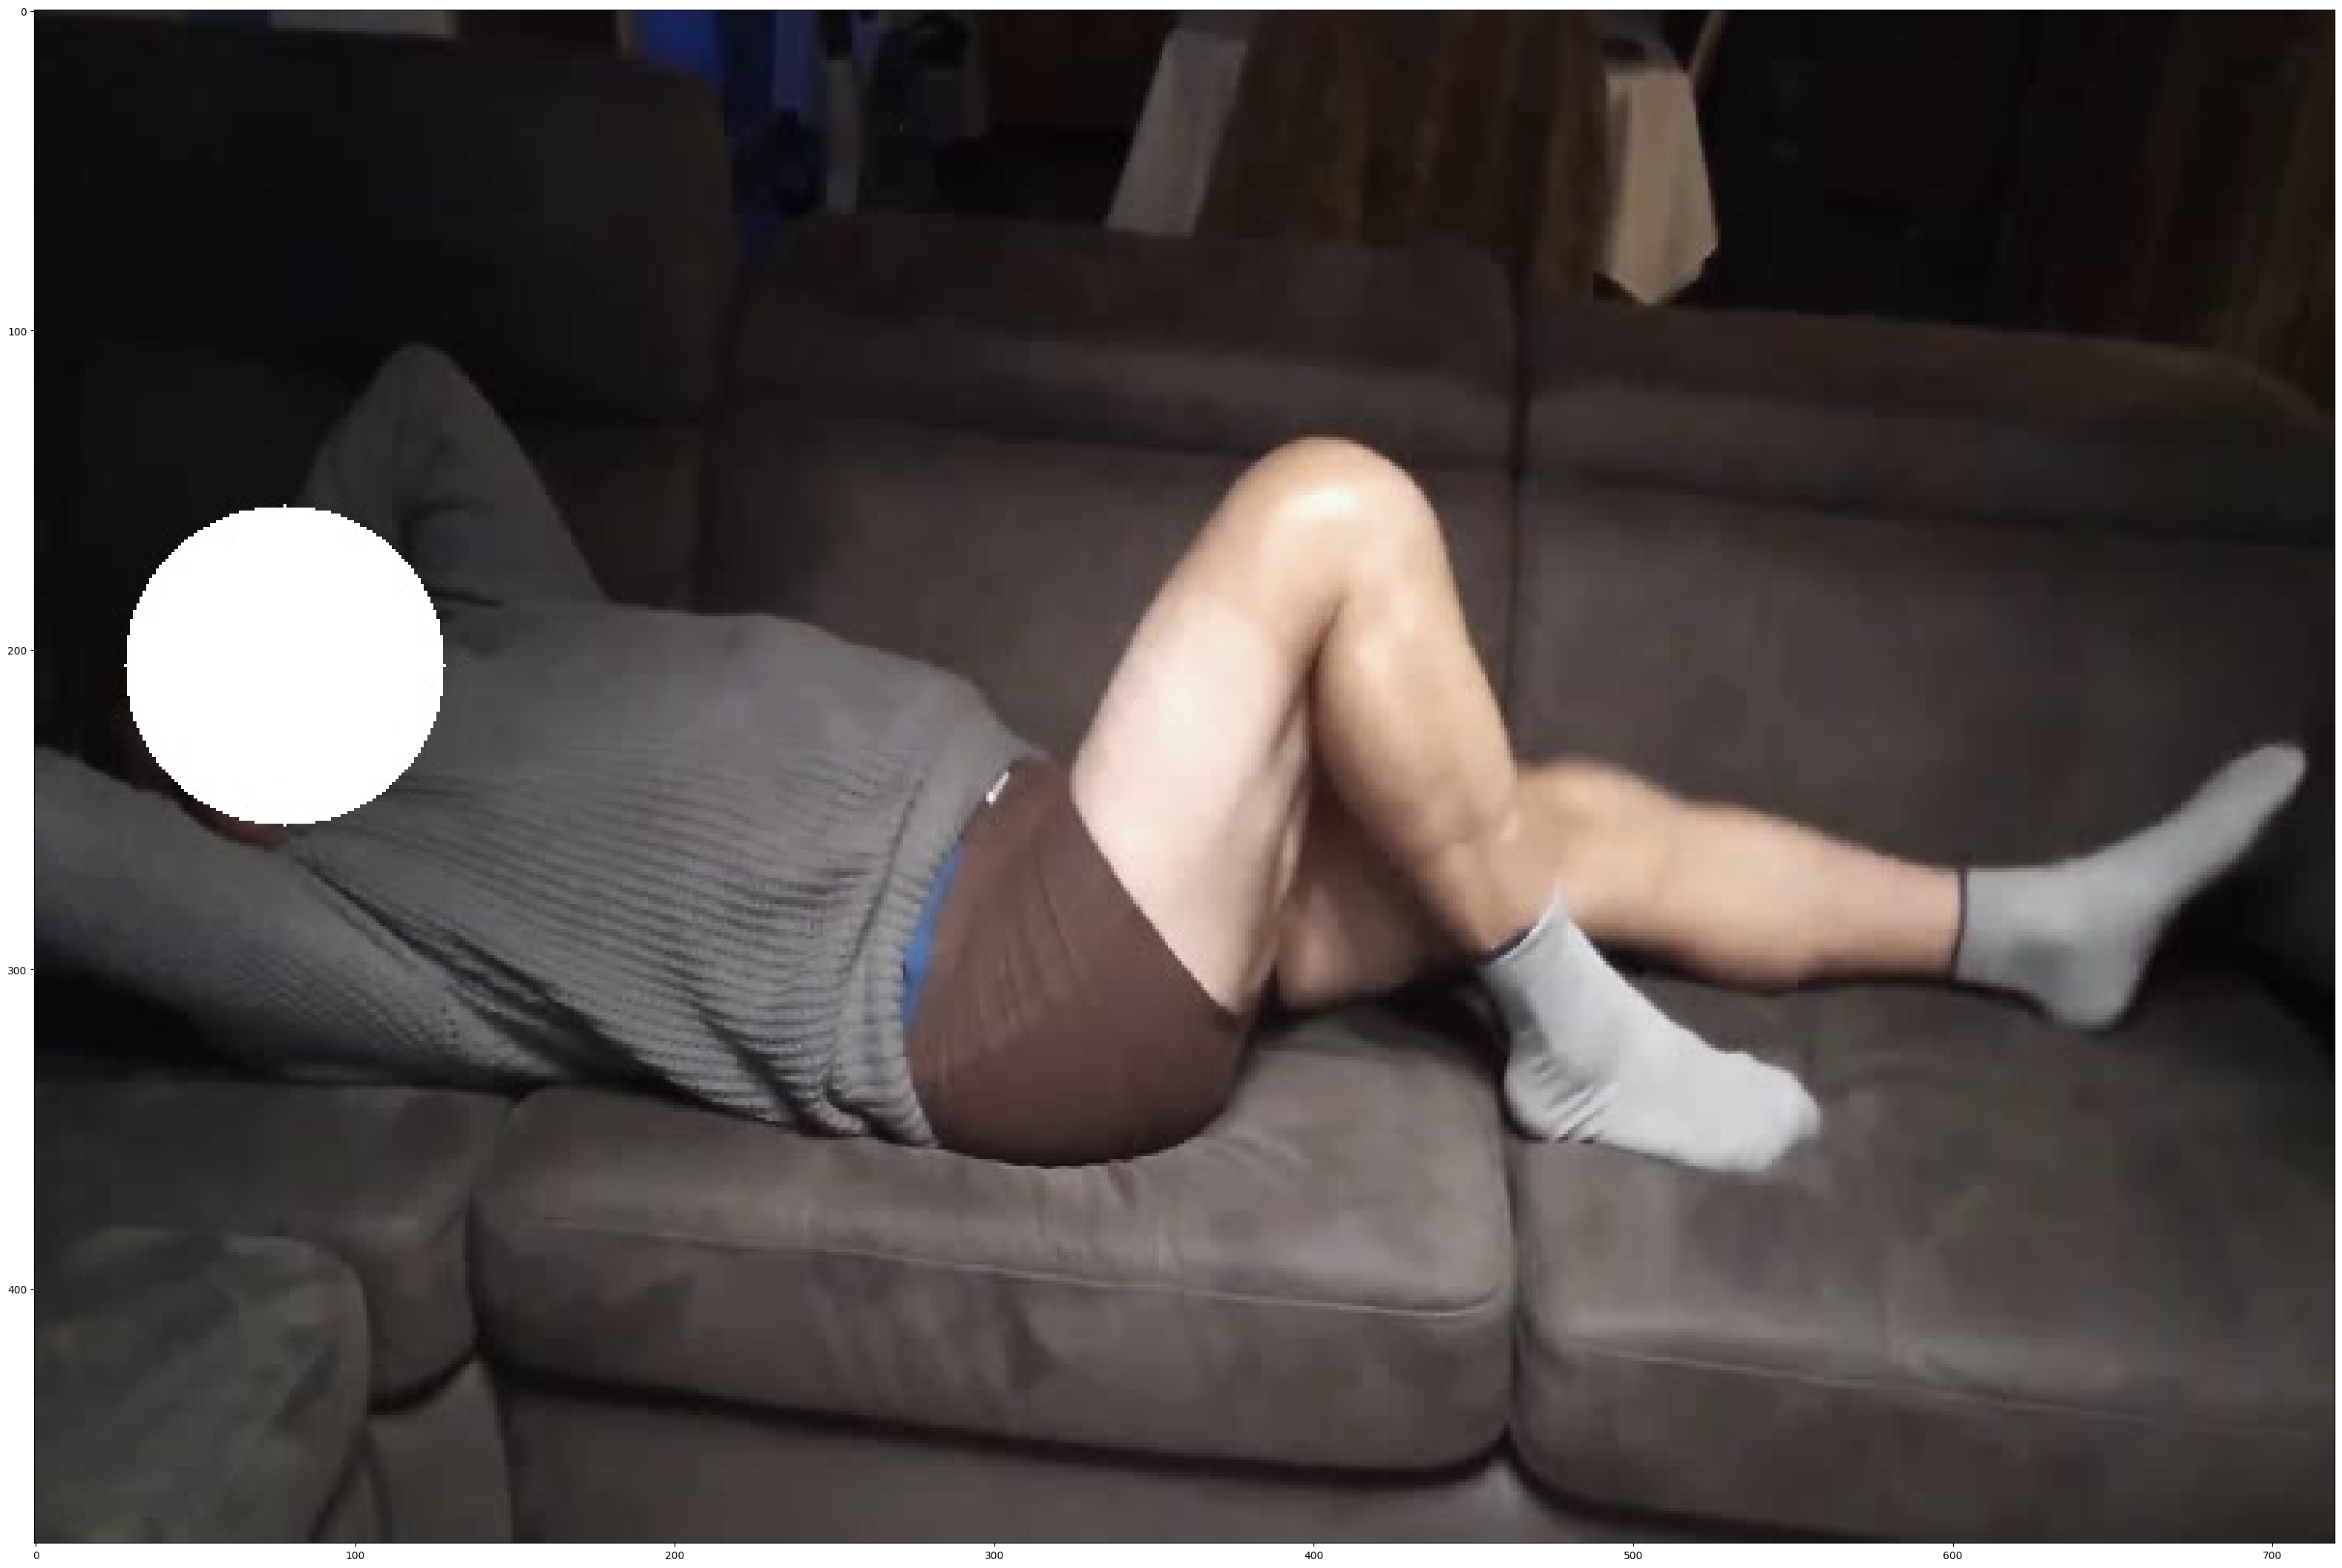

Error in callback <function flush_figures at 0x2a04bf600> (for post_execute):


KeyboardInterrupt: 

In [16]:
iterator = iter(data_loader_test)
for batch in iterator:
  images, targets = batch
  images = list(image.to(device) for image in images)

  with torch.no_grad():
      model.to(device)
      model.eval()
      output = model(images)

  #print("Predictions: \n", output)

  image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
  scores = output[0]['scores'].detach().cpu().numpy()

  high_scores_idxs = np.where(scores > 0.5)[0].tolist() # Indexes of boxes with scores > 0.7
  post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

  # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
  # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
  # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

  keypoints = []
  for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
      keypoints.append([list(map(int, kp[:2])) for kp in kps])

  bboxes = []
  for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
      bboxes.append(list(map(int, bbox.tolist())))
      
  visualize(image, bboxes, keypoints)

In [ ]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

(tensor([[[0.2000, 0.2000, 0.2000,  ..., 0.1059, 0.1059, 0.1059],
         [0.2039, 0.2039, 0.2039,  ..., 0.1059, 0.1059, 0.1059],
         [0.1961, 0.1961, 0.1961,  ..., 0.1059, 0.1059, 0.1059],
         ...,
         [0.1961, 0.1961, 0.2000,  ..., 0.1765, 0.1765, 0.1765],
         [0.1922, 0.1961, 0.1961,  ..., 0.1725, 0.1725, 0.1725],
         [0.1922, 0.1922, 0.1961,  ..., 0.1725, 0.1725, 0.1725]],

        [[0.1725, 0.1725, 0.1725,  ..., 0.0863, 0.0863, 0.0863],
         [0.1765, 0.1765, 0.1765,  ..., 0.0863, 0.0863, 0.0863],
         [0.1686, 0.1686, 0.1686,  ..., 0.0863, 0.0863, 0.0863],
         ...,
         [0.2000, 0.2000, 0.2039,  ..., 0.1608, 0.1608, 0.1608],
         [0.1961, 0.2000, 0.2000,  ..., 0.1569, 0.1569, 0.1569],
         [0.1961, 0.1961, 0.2000,  ..., 0.1569, 0.1569, 0.1569]],

        [[0.1490, 0.1490, 0.1490,  ..., 0.0706, 0.0706, 0.0706],
         [0.1529, 0.1529, 0.1529,  ..., 0.0706, 0.0706, 0.0706],
         [0.1451, 0.1451, 0.1451,  ..., 0.0706, 0.0706, 0

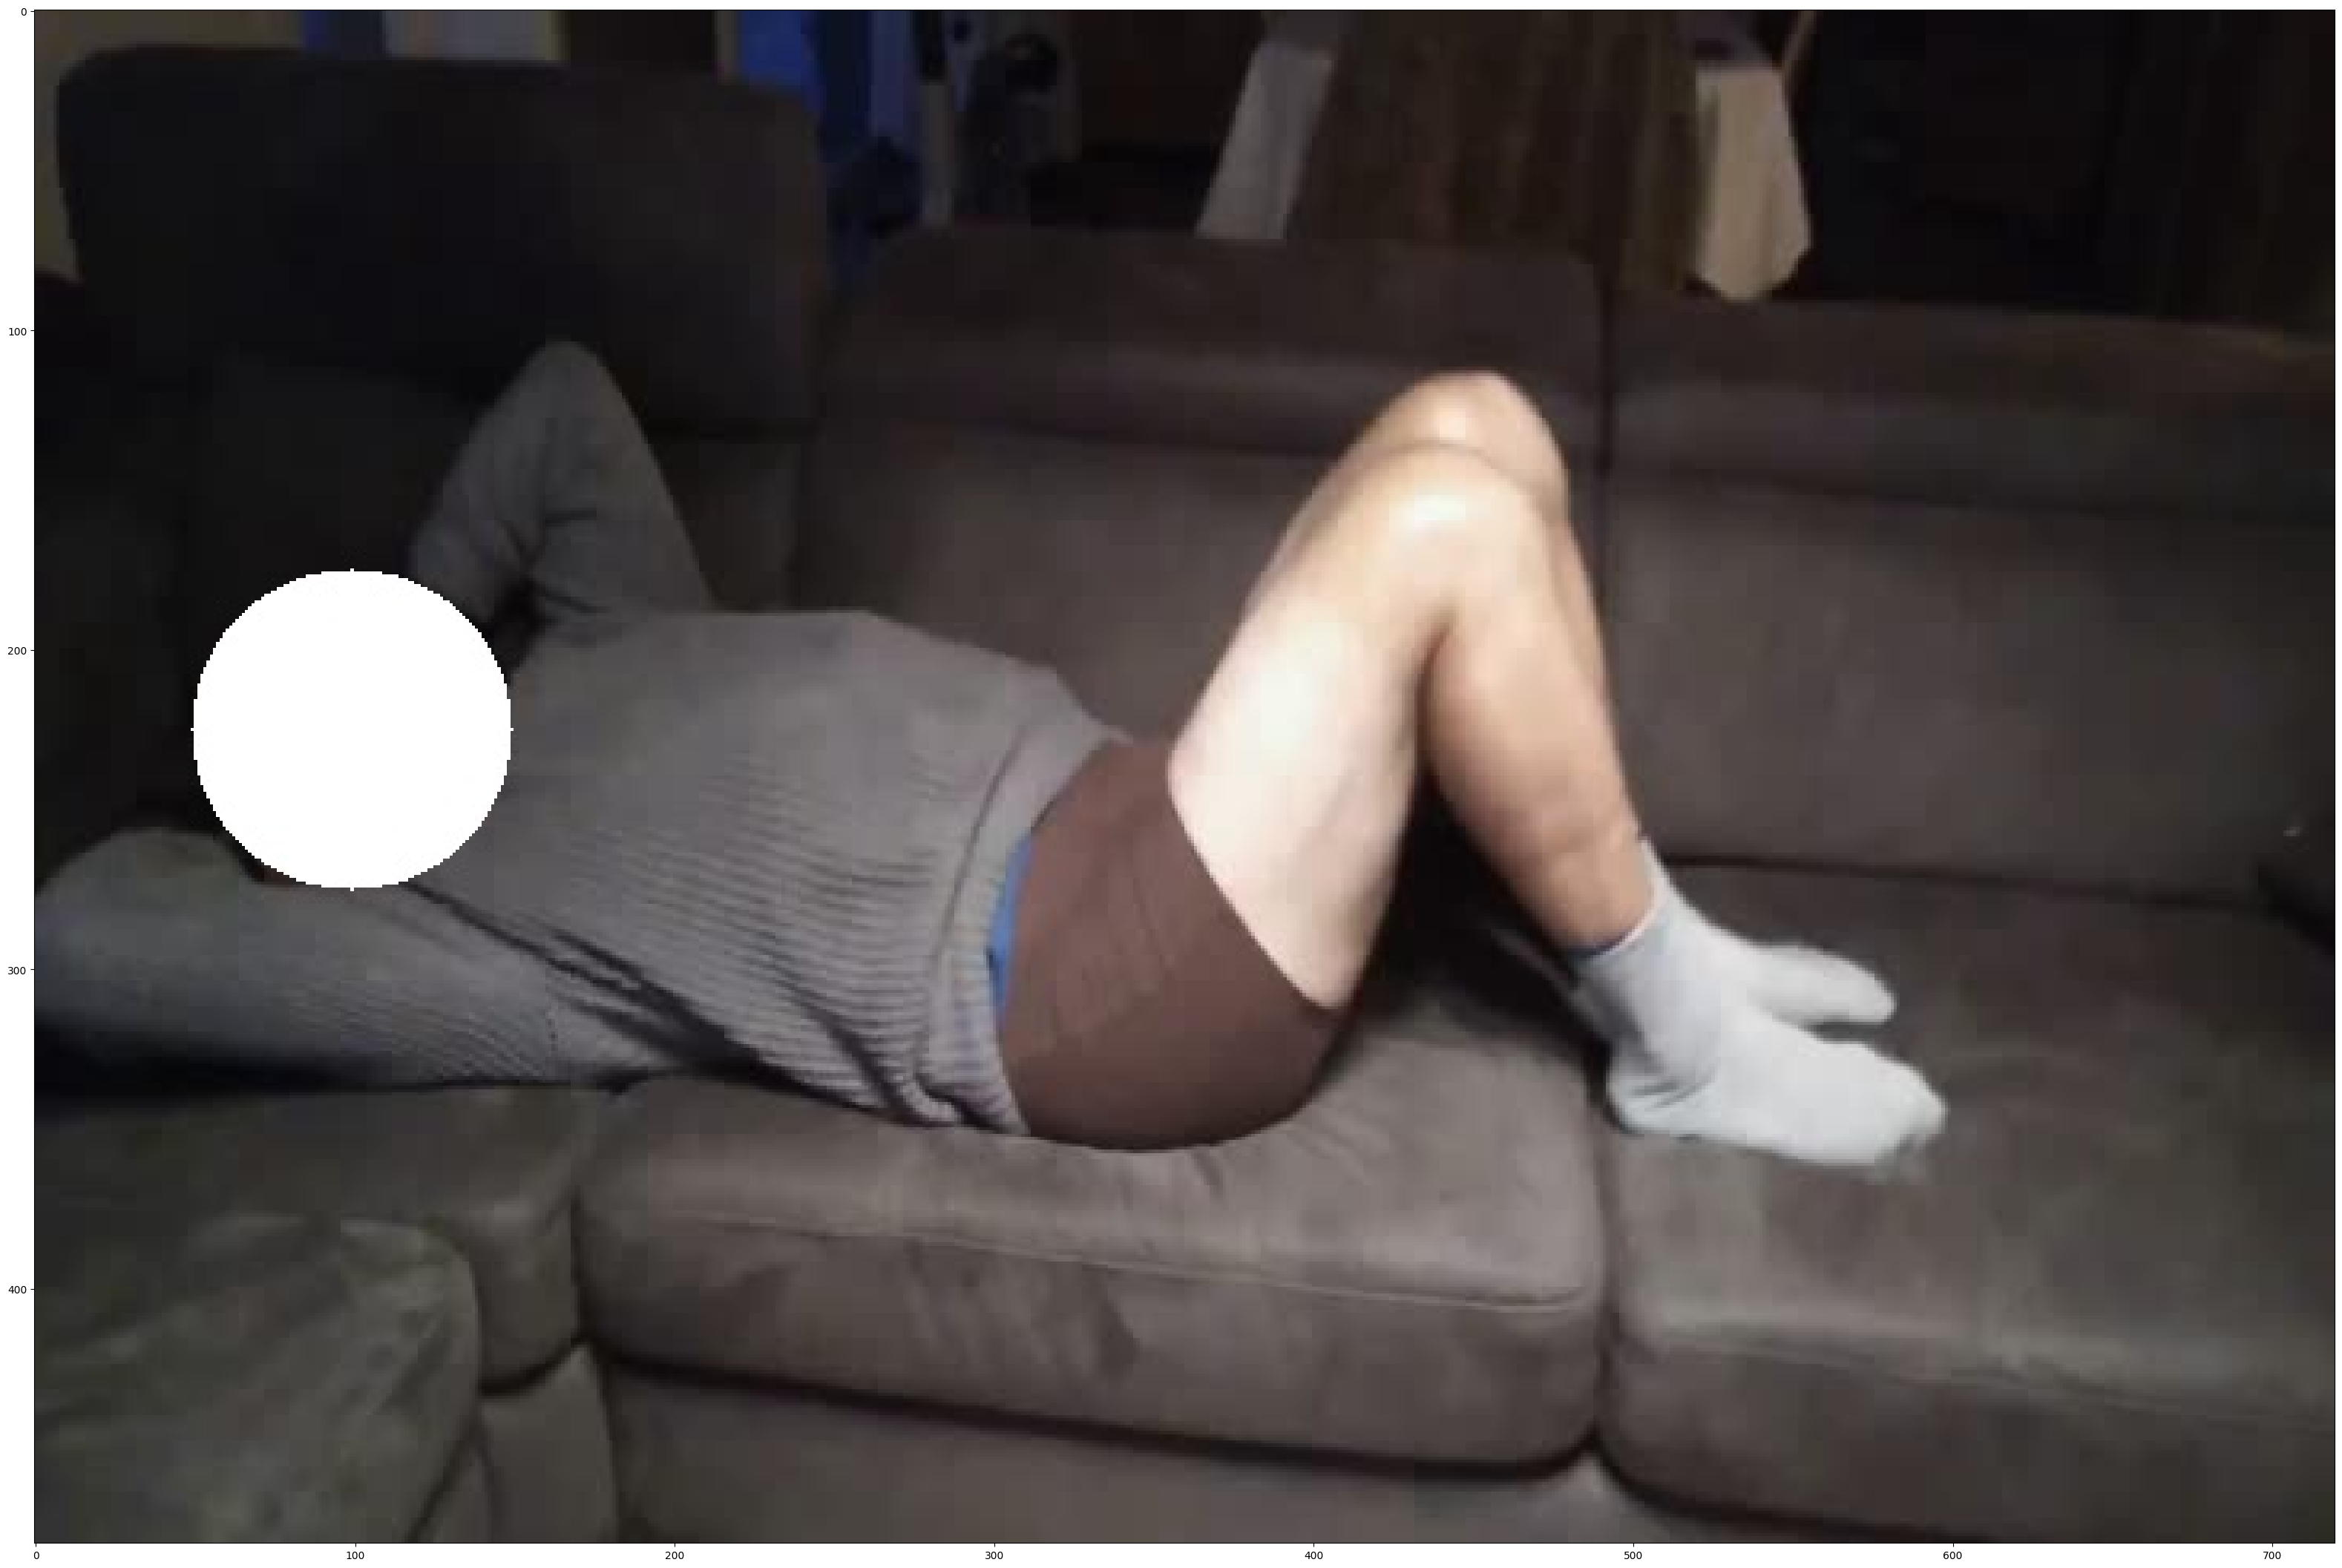

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)